# 2017_03_09 Data observation : from the raw data

- Reanalysis using
    - ```Freesurfer brain.mgz <--> Diffusion space```
    
    (It was `brain.mgz <--> co.nii.gz <--> diffusion space` in the previous version)

---

### Import libraries

In [1]:
import pandas as pd
import os
import re
import numpy as np
import nibabel
import argparse
import textwrap
import time
from multiprocessing import Pool
from numpy import count_nonzero
import statsmodels
import itertools

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats

%matplotlib inline

In [2]:
pd.set_option('max_columns',5000)

In [3]:
pwd

'/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script'

In [4]:
cortices = ["LPFC","LTC","MPFC",
            "MTC","OFC","PC","SMC","OCC"]

In [5]:
dataLoc = '/Volume/CCNC_W1_2T/2017_CHR_thalamus_microstructure_kcho/allData'
subjects = [x for x in os.listdir(dataLoc) \
                if x.startswith('NOR') or x.startswith('CHR')]

    !tree -n -L 2 $dataLoc/CHR13_KBK

# 0. loading the data from image files

In [6]:
def get_map(f):
    '''
    Load nifti file and return the data matrix of the image file
    '''
    return nibabel.load(f).get_data()

In [7]:
class thalamus:
    def __init__(self, param):
        # Expand from the input tuple
        dataLoc, subject = param
        
        subjDir = os.path.join(dataLoc, subject)
        roiDir = os.path.join(subjDir, 'ROI')
        
        dkiDir = os.path.join(subjDir, 'DKI')
        dtiDir = os.path.join(subjDir, 'DTI')

        df = pd.DataFrame()
        for side_s in 'lh', 'rh':
            
            # define side variables 
            if side_s=='lh':
                side = 'left'
            else:
                side = 'right'

            segDir = os.path.join(subjDir, 'segmentation', side)
            
            # MK file in original diffusion space
            mk_file = os.path.join(dkiDir, 'kmean.nii')
            mk_map = get_map(mk_file)

            # Thalamus ROI in Freesurfer space
            # Save the volume of the thalamus in self.thalamus_vol
            thalamus_file = os.path.join(roiDir, '{0}_thalamus.nii.gz'.format(side_s))
            thalamus_map = get_map(thalamus_file)
            thalamus_vol = count_nonzero(thalamus_map)

            
            
            for cortex in cortices:
                # seeds file in T1 space    
                seeds_in_raw = os.path.join(segDir, 'seeds_to_{side_s}_{cortex}.nii.gz'.format(
                        side_s=side_s, cortex=cortex))
                seeds_in_raw_map = get_map(seeds_in_raw)
                total_connectivity_raw = sum(seeds_in_raw_map[seeds_in_raw_map != 0])
                
               
                # Cortical roi in Freesurfer space
                cortical_roi = os.path.join(roiDir, '{side}_{cortex}.nii.gz'.format(
                        side=side_s, cortex=cortex))
                cortex_map = get_map(cortical_roi)
                cortical_roi_vol = count_nonzero(cortex_map)

                for threshold in ['5', '10', '20', '90', '95']:                    
                    thrDir = os.path.join(segDir, threshold+'thrP')
                    # seeds file in DKI space
                    seeds_in_dki = os.path.join(thrDir, 
                                                'dki_{threshold}_seeds_to_{side_s}_{cortex}.nii.gz'.format(
                            side_s=side_s, cortex=cortex, threshold=threshold))        
                    seeds_in_dki_map = get_map(seeds_in_dki)
                    total_connectivity = sum(seeds_in_dki_map[seeds_in_dki_map != 0])
                    thal_seg_volume = count_nonzero(seeds_in_dki_map)
                    thal_seg_mk = np.mean(mk_map[(seeds_in_dki_map > 0) & (mk_map != 0)])

                    df = pd.concat([
                                    df,
                                    pd.DataFrame([[subject, side, cortex, threshold, 
                                                   cortical_roi_vol, 
                                                   thalamus_vol, thal_seg_volume, thal_seg_mk,
                                                   total_connectivity,
                                                   total_connectivity_raw]],
                                                 columns = ['subject','side','cortex','threshold',
                                                            'cortex_volume', 'thalamus_volume', 
                                                            'thalamus_seg_volume', 'thalamus_seg_mk',
                                                            'total_connectivity',
                                                            'total_connectivity_raw']),
                               ])
        self.df = df.reset_index().drop('index', axis=1)

In [8]:
f = thalamus((dataLoc, subjects[0]))

f.df

In [10]:
# ```
subjects = [x for x in os.listdir(dataLoc) \
                if x.startswith('NOR') or x.startswith('CHR')]
# DKI/kmean.nii is not missing in NOR73_KMS (kmean2.nii existed)
# subjects.remove('NOR73_KMS')

thresholds = [10, 90, 95]
sides = ['lh', 'rh']
cortex = ['LPFC', 'LTC', 'MPFC', 'MTC', 'OCC', 'OFC', 'PC', 'SMC']
# a = [[dataLoc], subjects, sides, cortex, thresholds]
a = [[dataLoc], subjects]
all_combinations = list(itertools.product(*a))
pool = Pool()
outs = pool.map(thalamus, all_combinations)
merged_df = pd.concat([x.df for x in outs])
merged_df.to_csv('/home/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_one_reg_2017_03_10.csv')
# ```

/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kangik/

# 1. Data rearrange

### Load data

In [5]:
# ```
allData = pd.read_csv('/Users/kangik/Dropbox/project/2017_CHR_thalamic_nuclei/script/all_data_one_reg_2017_03_10.csv',
                       index_col=0)
allData['threshold'] = allData.threshold.astype('str')
allData['threshold'] = allData['threshold'].str[-2:]
allData['group'] = allData['subject'].str[:3]
# ```

In [6]:
# ```
total_connectivity_sum = allData.groupby(['threshold',
                                          'subject', 
                                          'side']).sum().reset_index()[['subject',
                                                                        'side',
                                                                        'threshold',
                                                                        'total_connectivity_raw']]
total_connectivity_sum.columns = ['subject', 'side', 'threshold', 'total_connectivity_raw_sum']

allData = pd.merge(allData,
                  total_connectivity_sum,
                  on=['subject','side','threshold'],
                  how='inner')
# ```

In [7]:
allData['relative_connectivity'] = allData.total_connectivity_raw / allData.total_connectivity_raw_sum

### Number of subjects in each group

In [8]:
allData.groupby(['group','side','cortex','threshold']).count()[['subject']]

subject
group side  cortex threshold         
CHR   left  LPFC   10              91
                   20              91
                   5               91
                   90              91
                   95              91
            LTC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
            MPFC   10              91
                   20              91
                   5               91
                   90              91
                   95              91
            MTC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
            OCC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
            OFC    10              91
                   20              91
                   5               91
                   90              91
                   95              91
...                               ...
NOR   right MPFC   10             100
                   20             100
                   5              100
                   90             100
                   95             100
            MTC    10             100
                   20             100
                   5              100
                   90             100
                   95             100
            OCC    10             100
                   20             100
                   5              100
                   90             100
                   95             100
            OFC    10             100
                   20             100
                   5              100
                   90             100
                   95             100
            PC     10             100
                   20             100
                   5              100
                   90             100
                   95             100
            SMC    10             100
                   20             100
                   5              100
                   90             100
                   95             100

[160 rows x 1 columns]

### Load matched group list

In [9]:
f = pd.ExcelFile('CHR_NOR_match_20160831.xlsx')
data_locking_df = f.parse(0)

In [10]:
data_locking_df.columns

Index(['koreanName', 'subjectName', 'subjectInitial', 'group', 'sex', 'age',
       'handedness', 'DOB', 'scanDate', 'timeline', 'studyname',
       'patientNumber', 'T1Number', 'DTINumber', 'DKINumber', 'RESTNumber',
       'REST2Number', 'folderName', 'backUpBy', 'note', 'Unnamed: 20'],
      dtype='object')

> Are there only baseline files ?

In [11]:
data_locking_df.timeline.unique()

array(['baseline'], dtype=object)

### Extracting the matched set data

> List of subjects 

- only in the matched set 
- but not in the data set

In [12]:
[x for x in data_locking_df.folderName if x not in allData.subject.unique()]

['CHR02_JHJ', 'CHR32_CWJ', 'CHR36_KJH']

In [13]:
len(allData.subject.unique())

191

In [14]:
len(data_locking_df.folderName.unique())

157

In [15]:
df_matched = pd.merge(allData,
                      data_locking_df[['folderName','sex','age','handedness','DKINumber','note']],
                      left_on='subject',
                      right_on='folderName',
                      how='inner')

In [16]:
df_matched[['group','subject']].drop_duplicates().groupby('group').count()

subject
group         
CHR         76
NOR         78

### NOR (78) vs CHR (76)

----

# 2. Data exploration

In [17]:
df_matched.columns

Index(['subject', 'side', 'cortex', 'threshold', 'cortex_volume',
       'thalamus_volume', 'thalamus_seg_volume', 'thalamus_seg_mk',
       'total_connectivity', 'total_connectivity_raw', 'group',
       'total_connectivity_raw_sum', 'relative_connectivity', 'folderName',
       'sex', 'age', 'handedness', 'DKINumber', 'note'],
      dtype='object')

In [18]:
df_matched = df_matched[[u'subject',
                         u'side',
                         u'cortex',
                         u'threshold',
                         u'cortex_volume',
                         u'thalamus_volume',
                         u'thalamus_seg_volume',     
                         u'thalamus_seg_mk',  
                         u'total_connectivity', 
                         u'total_connectivity_raw', 
                         u'relative_connectivity',
                         u'group',
                         u'folderName',
                         u'sex',
                         u'age',
                         u'handedness']]

In [19]:
df_matched['subject'] = df_matched.subject.str[:5]

In [20]:
df_matched.describe()

/Users/kangik/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


cortex_volume  thalamus_volume  thalamus_seg_volume  thalamus_seg_mk  \
count   12320.000000     12320.000000         12320.000000     12270.000000   
mean    32180.259740      8844.792208           380.038880         0.949636   
std     14532.146056       930.567160           280.214482         0.145076   
min     11214.000000      6677.000000             0.000000         0.369008   
25%     19830.250000      8251.500000           127.000000              NaN   
50%     29192.000000      8762.000000           331.000000              NaN   
75%     40524.750000      9362.250000           596.000000              NaN   
max     79156.000000     12415.000000          1396.000000         1.526880   

       total_connectivity  total_connectivity_raw  relative_connectivity  \
count        1.232000e+04            1.232000e+04           12320.000000   
mean         8.135414e+04            1.607790e+06               0.125000   
std          1.394753e+05            2.239171e+06               0.143631   
min          0.000000e+00            0.000000e+00               0.000000   
25%          4.467830e+03            1.086018e+05               0.027276   
50%          2.380655e+04            5.529480e+05               0.071580   
75%          8.620030e+04            2.251440e+06               0.172871   
max          1.126617e+06            1.411824e+07               0.890940   

                sex           age    handedness  
count  12320.000000  12320.000000  12320.000000  
mean       1.305195     21.714286      1.077922  
std        0.460509      3.364801      0.268060  
min        1.000000     17.000000      1.000000  
25%        1.000000     19.000000      1.000000  
50%        1.000000     21.000000      1.000000  
75%        2.000000     24.000000      1.000000  
max        2.000000     34.000000      2.000000

In [21]:
df_matched[df_matched.isnull().any(axis=1)]

subject   side cortex threshold  cortex_volume  thalamus_volume  \
2327    NOR06   left    OCC         5          22790             9162   
2335    NOR06   left    OCC        10          22790             9162   
2343    NOR06   left    OCC        20          22790             9162   
2351    NOR06   left    OCC        90          22790             9162   
2359    NOR06   left    OCC        95          22790             9162   
2367    NOR06  right    OCC         5          21916             8027   
2375    NOR06  right    OCC        10          21916             8027   
2383    NOR06  right    OCC        20          21916             8027   
2391    NOR06  right    OCC        90          21916             8027   
2399    NOR06  right    OCC        95          21916             8027   
3607    NOR49   left    OCC         5          21659             8284   
3615    NOR49   left    OCC        10          21659             8284   
3623    NOR49   left    OCC        20          21659             8284   
3631    NOR49   left    OCC        90          21659             8284   
3639    NOR49   left    OCC        95          21659             8284   
6007    CHR53   left    OCC         5          27282             8763   
6015    CHR53   left    OCC        10          27282             8763   
6023    CHR53   left    OCC        20          27282             8763   
6031    CHR53   left    OCC        90          27282             8763   
6039    CHR53   left    OCC        95          27282             8763   
7807    NOR46  right    OCC         5          24417             9325   
7815    NOR46  right    OCC        10          24417             9325   
7823    NOR46  right    OCC        20          24417             9325   
7831    NOR46  right    OCC        90          24417             9325   
7839    NOR46  right    OCC        95          24417             9325   
8527    NOR80  right    OCC         5          25864             8394   
8535    NOR80  right    OCC        10          25864             8394   
8543    NOR80  right    OCC        20          25864             8394   
8551    NOR80  right    OCC        90          25864             8394   
8559    NOR80  right    OCC        95          25864             8394   
8847    NOR87  right    OCC         5          26103             8688   
8855    NOR87  right    OCC        10          26103             8688   
8863    NOR87  right    OCC        20          26103             8688   
8871    NOR87  right    OCC        90          26103             8688   
8879    NOR87  right    OCC        95          26103             8688   
9047    NOR92   left    OCC         5          20158             9542   
9055    NOR92   left    OCC        10          20158             9542   
9063    NOR92   left    OCC        20          20158             9542   
9071    NOR92   left    OCC        90          20158             9542   
9079    NOR92   left    OCC        95          20158             9542   
9087    NOR92  right    OCC         5          24964             8718   
9095    NOR92  right    OCC        10          24964             8718   
9103    NOR92  right    OCC        20          24964             8718   
9111    NOR92  right    OCC        90          24964             8718   
9119    NOR92  right    OCC        95          24964             8718   
11687   CHR38   left    OCC         5          20951             7491   
11695   CHR38   left    OCC        10          20951             7491   
11703   CHR38   left    OCC        20          20951             7491   
11711   CHR38   left    OCC        90          20951             7491   
11719   CHR38   left    OCC        95          20951             7491   

       thalamus_seg_volume  thalamus_seg_mk  total_connectivity  \
2327                     0              NaN                 0.0   
2335                     0              NaN                 0.0   
2343                     0              NaN                 0.0   
2351          

In [22]:
df_matched[df_matched.thalamus_seg_volume==0]

subject   side cortex threshold  cortex_volume  thalamus_volume  \
2327    NOR06   left    OCC         5          22790             9162   
2335    NOR06   left    OCC        10          22790             9162   
2343    NOR06   left    OCC        20          22790             9162   
2351    NOR06   left    OCC        90          22790             9162   
2359    NOR06   left    OCC        95          22790             9162   
2367    NOR06  right    OCC         5          21916             8027   
2375    NOR06  right    OCC        10          21916             8027   
2383    NOR06  right    OCC        20          21916             8027   
2391    NOR06  right    OCC        90          21916             8027   
2399    NOR06  right    OCC        95          21916             8027   
3607    NOR49   left    OCC         5          21659             8284   
3615    NOR49   left    OCC        10          21659             8284   
3623    NOR49   left    OCC        20          21659             8284   
3631    NOR49   left    OCC        90          21659             8284   
3639    NOR49   left    OCC        95          21659             8284   
6007    CHR53   left    OCC         5          27282             8763   
6015    CHR53   left    OCC        10          27282             8763   
6023    CHR53   left    OCC        20          27282             8763   
6031    CHR53   left    OCC        90          27282             8763   
6039    CHR53   left    OCC        95          27282             8763   
7807    NOR46  right    OCC         5          24417             9325   
7815    NOR46  right    OCC        10          24417             9325   
7823    NOR46  right    OCC        20          24417             9325   
7831    NOR46  right    OCC        90          24417             9325   
7839    NOR46  right    OCC        95          24417             9325   
8527    NOR80  right    OCC         5          25864             8394   
8535    NOR80  right    OCC        10          25864             8394   
8543    NOR80  right    OCC        20          25864             8394   
8551    NOR80  right    OCC        90          25864             8394   
8559    NOR80  right    OCC        95          25864             8394   
8847    NOR87  right    OCC         5          26103             8688   
8855    NOR87  right    OCC        10          26103             8688   
8863    NOR87  right    OCC        20          26103             8688   
8871    NOR87  right    OCC        90          26103             8688   
8879    NOR87  right    OCC        95          26103             8688   
9047    NOR92   left    OCC         5          20158             9542   
9055    NOR92   left    OCC        10          20158             9542   
9063    NOR92   left    OCC        20          20158             9542   
9071    NOR92   left    OCC        90          20158             9542   
9079    NOR92   left    OCC        95          20158             9542   
9087    NOR92  right    OCC         5          24964             8718   
9095    NOR92  right    OCC        10          24964             8718   
9103    NOR92  right    OCC        20          24964             8718   
9111    NOR92  right    OCC        90          24964             8718   
9119    NOR92  right    OCC        95          24964             8718   
11687   CHR38   left    OCC         5          20951             7491   
11695   CHR38   left    OCC        10          20951             7491   
11703   CHR38   left    OCC        20          20951             7491   
11711   CHR38   left    OCC        90          20951             7491   
11719   CHR38   left    OCC        95          20951             7491   

       thalamus_seg_volume  thalamus_seg_mk  total_connectivity  \
2327                     0              NaN                 0.0   
2335                     0              NaN                 0.0   
2343                     0              NaN                 0.0   
2351          

In [23]:
df_matched[(df_matched.subject=='NOR80_CHM') & (df_matched.cortex=='OCC') & (df_matched.side=='right')]

Empty DataFrame
Columns: [subject, side, cortex, threshold, cortex_volume, thalamus_volume, thalamus_seg_volume, thalamus_seg_mk, total_connectivity, total_connectivity_raw, relative_connectivity, group, folderName, sex, age, handedness]
Index: []

> foward fill the missing data

In [24]:
df_matched.loc[df_matched.thalamus_seg_volume==0, 'thalamus_seg_volume'] = 0

In [25]:
df_matched.thalamus_seg_mk = df_matched.thalamus_seg_mk.fillna(method='ffill')

> Recheck

In [26]:
df_matched[df_matched.isnull().any(axis=1)]

Empty DataFrame
Columns: [subject, side, cortex, threshold, cortex_volume, thalamus_volume, thalamus_seg_volume, thalamus_seg_mk, total_connectivity, total_connectivity_raw, relative_connectivity, group, folderName, sex, age, handedness]
Index: []

In [27]:
df_matched.threshold = df_matched.threshold.astype('str')

# Graphs

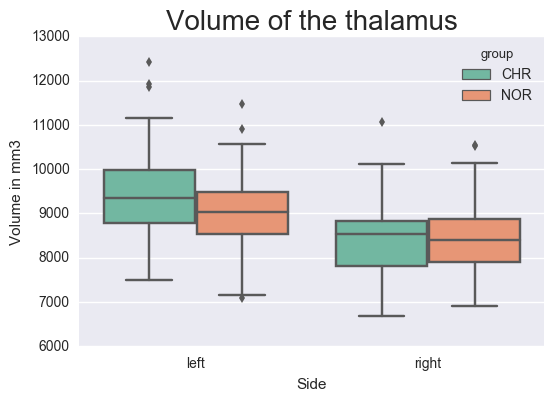

In [28]:
sns.boxplot('side','thalamus_volume', 
            hue='group', 
            palette=sns.color_palette("Set2", 2), 
            data=df_matched[['side','thalamus_volume','group']].drop_duplicates())
plt.title('Volume of the thalamus', fontsize=20)
plt.ylabel('Volume in mm3')
plt.xlabel('Side')
plt.show()

/Users/kangik/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


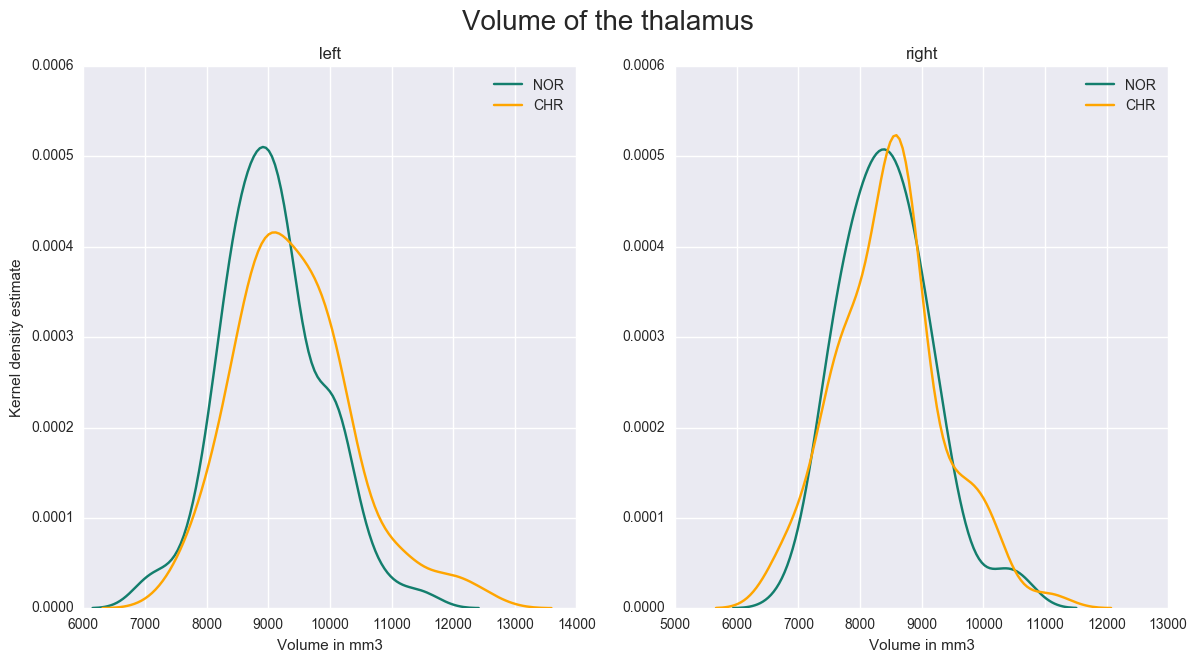

In [29]:
gb = df_matched[['side','thalamus_volume','group']].drop_duplicates().groupby(['group','side'])
var = 'thalamus_volume'

fig, axes = plt.subplots(ncols=2, figsize=(14,7))
for num, side in enumerate(['left','right']):
    sns.kdeplot(gb.get_group(('NOR',side))[var], label='NOR', ax=axes[num], color=sns.xkcd_rgb['blue green'])
    sns.kdeplot(gb.get_group(('CHR',side))[var], label='CHR', ax=axes[num], color='orange')
    axes[num].set_title(side)
    axes[num].set_xlabel('Volume in mm3')

fig.suptitle('Volume of the thalamus', fontsize=20)
axes[0].set_ylabel('Kernel density estimate')

plt.show()

             df        sum_sq       mean_sq         F    PR(>F)
GROUP       1.0  4.851624e+06  4.851624e+06  6.356798  0.012738
AGE         1.0  5.269816e+05  5.269816e+05  0.690473  0.407324
SEX         1.0  4.126885e+06  4.126885e+06  5.407216  0.021394
Residual  150.0  1.144827e+08  7.632182e+05       NaN       NaN


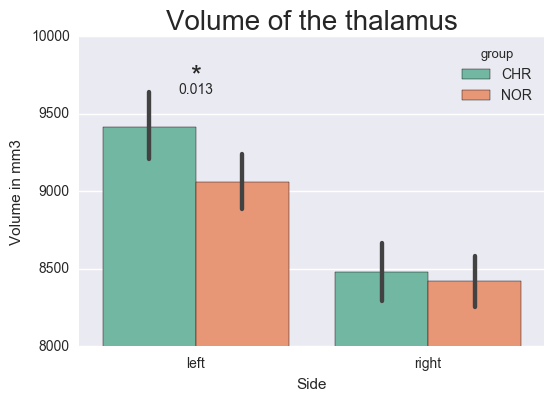

In [30]:
df = df_matched[['subject',
                 'side',
                 'thalamus_volume',
                 'age',
                 'sex',
                 'group']].drop_duplicates()

ax = sns.barplot('side','thalamus_volume', 
                 hue = 'group', 
                 palette = sns.color_palette("Set2", 2), 
                 data = df)
ax.set_title('Volume of the thalamus', fontsize=20)
ax.set_ylabel('Volume in mm3')
ax.set_ylim(8000, 10000)
ax.set_xlabel('Side')

compare = 'thalamus_volume'

for num, side in enumerate(['left', 'right']):
    x = df.groupby('side').get_group(side)
    GROUP = x['group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']
    
    formula = 'VAR ~ GROUP + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:
        print(output)
        gb = x.groupby('group')
        
        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        ax.annotate("*", 
                    xy=(num, group_mean_upper+group_std_upper/3), 
                    va='center', ha='center', fontsize=20)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                    xy=(num, group_mean_upper+group_std_upper/4), 
                    va='center', ha='center', fontsize=10)
        
plt.show()

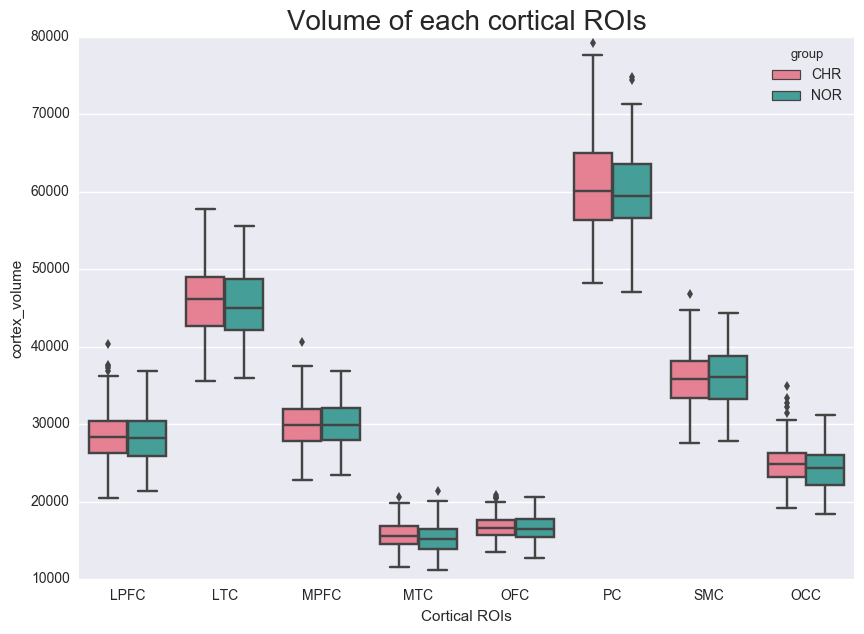

In [31]:
ax = plt.figure(figsize=(10,7))
ax = sns.boxplot('cortex','cortex_volume', 
                 hue='group', 
                 palette=sns.color_palette("husl",2),
                 data=df_matched[['subject', 'cortex','cortex_volume','group']].drop_duplicates())
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')
plt.show()

             df        sum_sq       mean_sq          F        PR(>F)
GROUP       1.0  2.702659e+07  2.702659e+07   4.265739  3.973570e-02
AGE         1.0  9.335310e+06  9.335310e+06   1.473438  2.257462e-01
SEX         1.0  4.332954e+08  4.332954e+08  68.389142  4.239301e-15
Residual  304.0  1.926063e+09  6.335734e+06        NaN           NaN


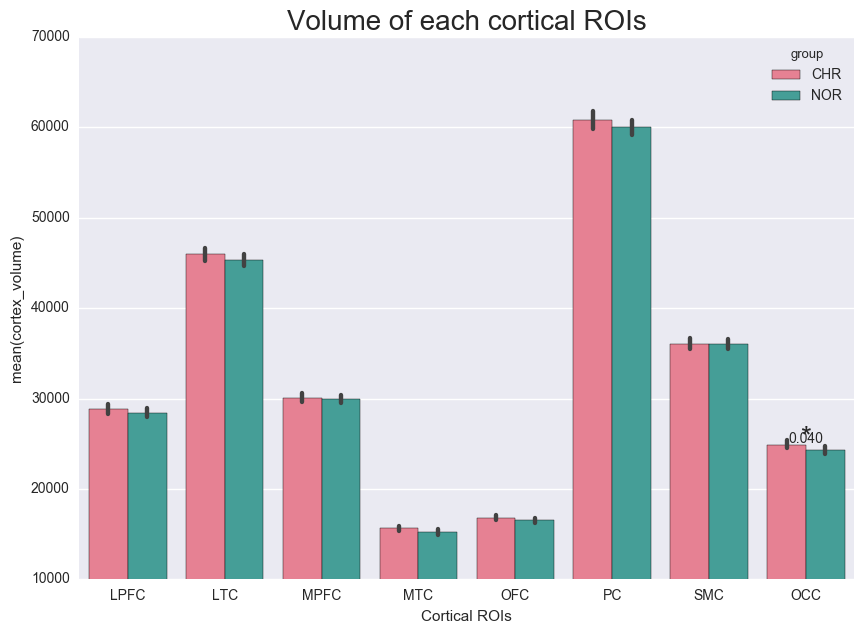

In [32]:
ax = plt.figure(figsize=(10,7))
ax = sns.barplot('cortex','cortex_volume', 
                 hue='group', 
                 palette=sns.color_palette("husl",2),
                 data=df_matched[['subject', 
                                  'cortex', 
                                  'cortex_volume',
                                  'group']].drop_duplicates())
ax.set_ylim(10000, 70000)
ax.set_title('Volume of each cortical ROIs', fontsize=20)
ax.set_xlabel('Cortical ROIs')


compare = 'cortex_volume'
for num, cortex in enumerate(df_matched.cortex.unique()):
    x = df_matched[['subject',
                    'cortex_volume', 
                    'group', 
                    'cortex', 
                    'age', 
                    'sex']].drop_duplicates().groupby('cortex').get_group(cortex)
    GROUP = x['group']
    VAR = x[compare]
    AGE = x['age']
    SEX = x['sex']

    formula = 'VAR ~ GROUP + AGE + SEX'
    lm = ols(formula, x).fit()
    output = anova_lm(lm)
    if output['PR(>F)'].GROUP < 0.05:

        print(output)
        gb = x.groupby('group')

        if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
            group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
        else:
            group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
            group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

        conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

        conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
        ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
#         print(conf_int_a)
#         ax.annotate("*", 
#                     xy=(num, conf_int_a[1]), 
#                     va='center', ha='center', fontsize=20)

plt.show()

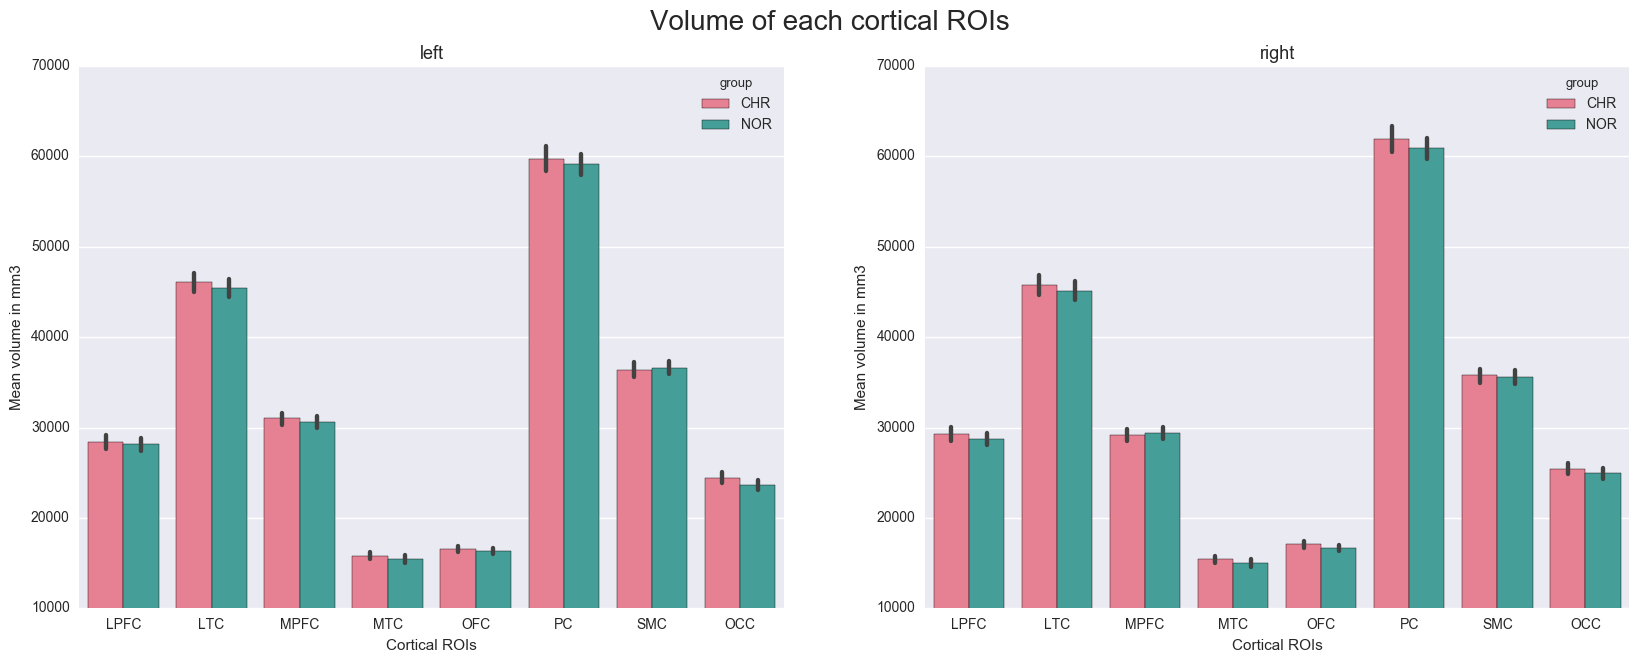

In [33]:
df_gb = df_matched.groupby('side')
fig, axes = plt.subplots(ncols=2, figsize=(20,7))
for side_num, side in enumerate(['left','right']):
    df = df_gb.get_group(side)[['cortex',
                                'cortex_volume',
                                'subject',
                                'group',
                                'age',
                                'sex']].drop_duplicates()
    
    sns.barplot('cortex',
                'cortex_volume',
                hue='group', 
                palette=sns.color_palette("husl",2),
                data=df, 
                ax=axes[side_num])
    
    axes[side_num].set_ylim(10000, 70000)
    axes[side_num].set_title(side, fontsize=13)
    axes[side_num].set_xlabel('Cortical ROIs')
    axes[side_num].set_ylabel('Mean volume in mm3')

    compare = 'cortex_volume'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df.groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        
        # If there is significant group effect
        if output['PR(>F)'].GROUP < 0.05:
            print(output)
            gb = x.groupby('group')
            groups = list(gb.groups.keys())

            # Determine the upper boundary of the plot
            # If the first group has higher mean than the second group
            if gb.get_group(groups[0])[compare].mean() > gb.get_group(groups[1])[compare].mean():
                group_mean_upper = gb.get_group(groups[0])[compare].mean()
                group_std_upper = gb.get_group(groups[0])[compare].std()
            # If the second group has higher mean than the second group
            else:
                group_mean_upper = gb.get_group(groups[1])[compare].mean()
                group_std_upper = gb.get_group(groups[1])[compare].std()
            
            # Estimate confidence interval
            # Edit here to make the significant sign higher up from the bar plot
            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('*', 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=20)
            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            axes[side_num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                    xy=(num, conf_int_a[1]), 
                                    va='center', 
                                    ha='center', 
                                    fontsize=10)
            
fig.suptitle('Volume of each cortical ROIs', fontsize=20)
plt.show()


In [34]:
df_matched.head()

subject  side cortex threshold  cortex_volume  thalamus_volume  \
0   CHR04  left   LPFC         5          30171            10032   
1   CHR04  left    LTC         5          47297            10032   
2   CHR04  left   MPFC         5          30242            10032   
3   CHR04  left    MTC         5          18015            10032   
4   CHR04  left    OFC         5          16580            10032   

   thalamus_seg_volume  thalamus_seg_mk  total_connectivity  \
0                  520         0.829182       229689.476292   
1                 1014         0.793938       148975.244996   
2                  908         0.767550       175404.579798   
3                 1028         0.781127       190459.817848   
4                  740         0.792501       553059.446961   

   total_connectivity_raw  relative_connectivity group folderName  sex  age  \
0               2932619.0               0.118277   CHR  CHR04_PJH    1   24   
1               1889038.0               0.076188   CHR  CHR04_PJH    1   24   
2               2253434.0               0.090885   CHR  CHR04_PJH    1   24   
3               2498761.0               0.100779   CHR  CHR04_PJH    1   24   
4               7005886.0               0.282559   CHR  CHR04_PJH    1   24   

   handedness  
0           1  
1           1  
2           1  
3           1  
4           1

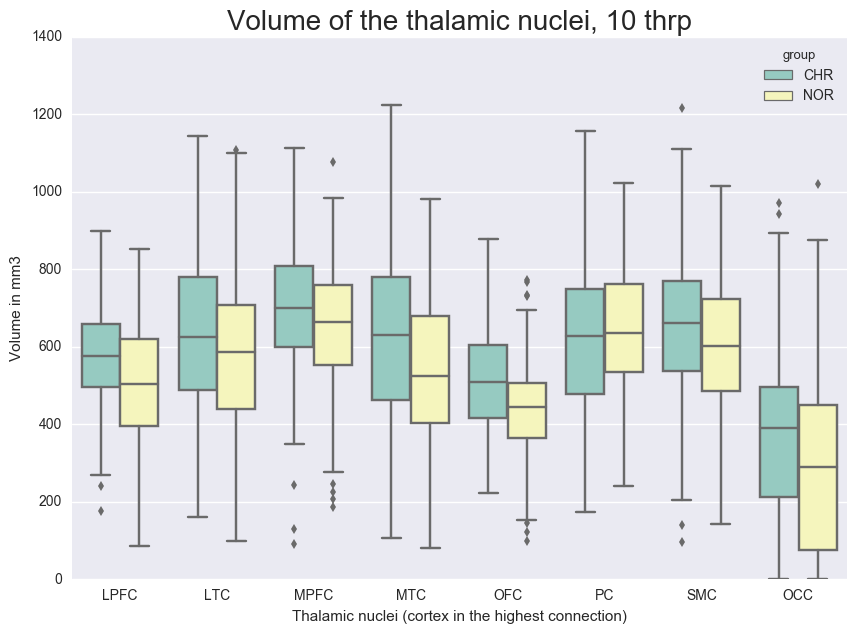

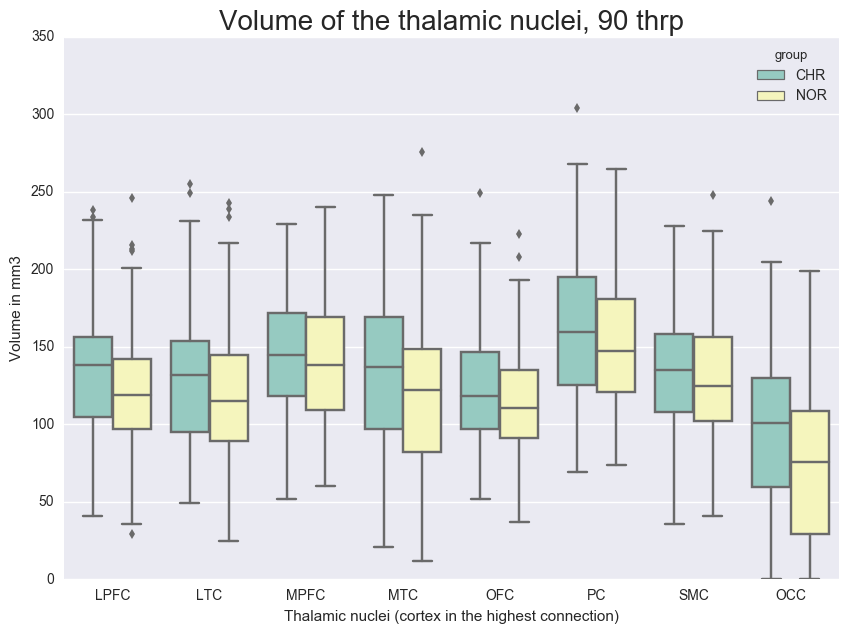

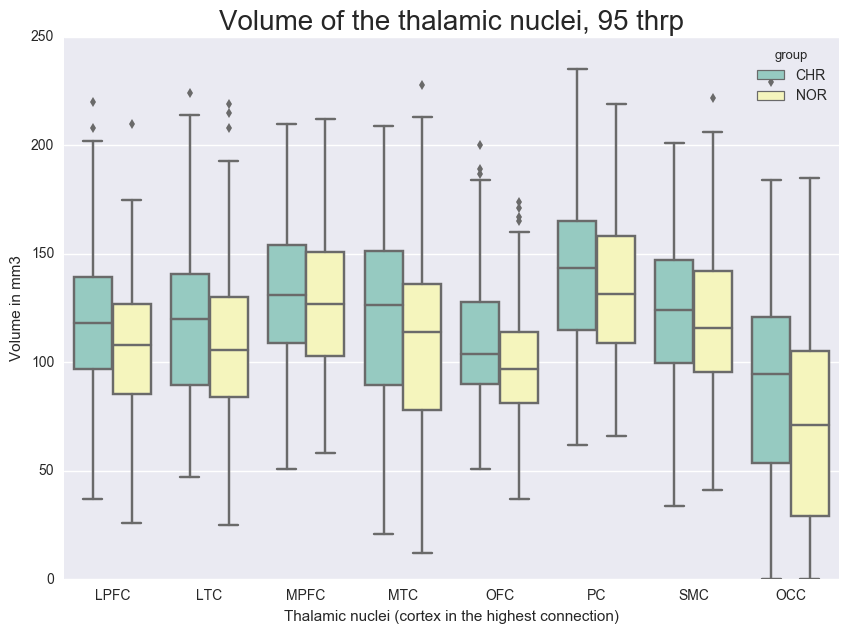

In [35]:
for thr in '10', '90', '95':
#     mk = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex', 'thalamus_seg_volume', 
                     hue='group', palette=sns.color_palette("Set3", 2),
                data=df_matched[['subject',
                                 'cortex',
                                 'thalamus_seg_volume',
                                 'group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    
    plt.show()

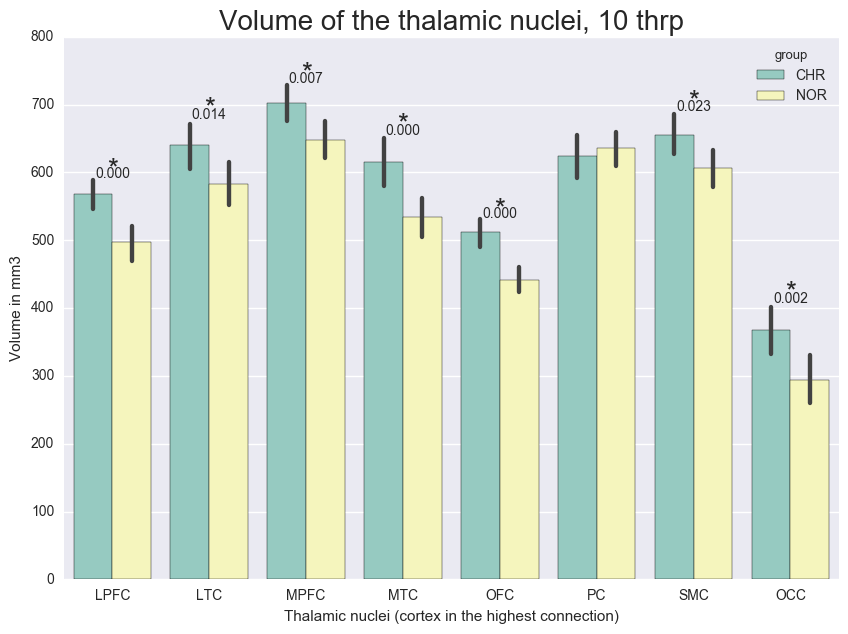

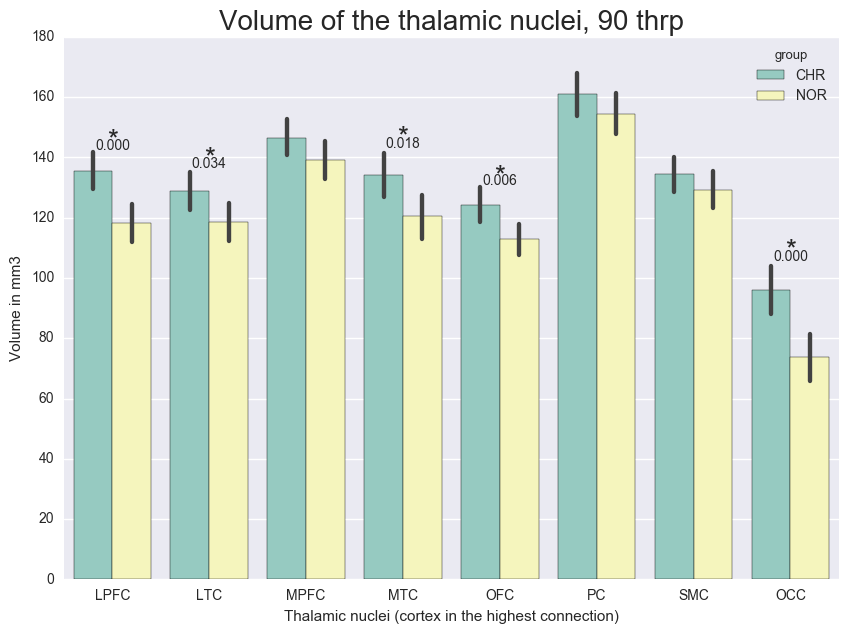

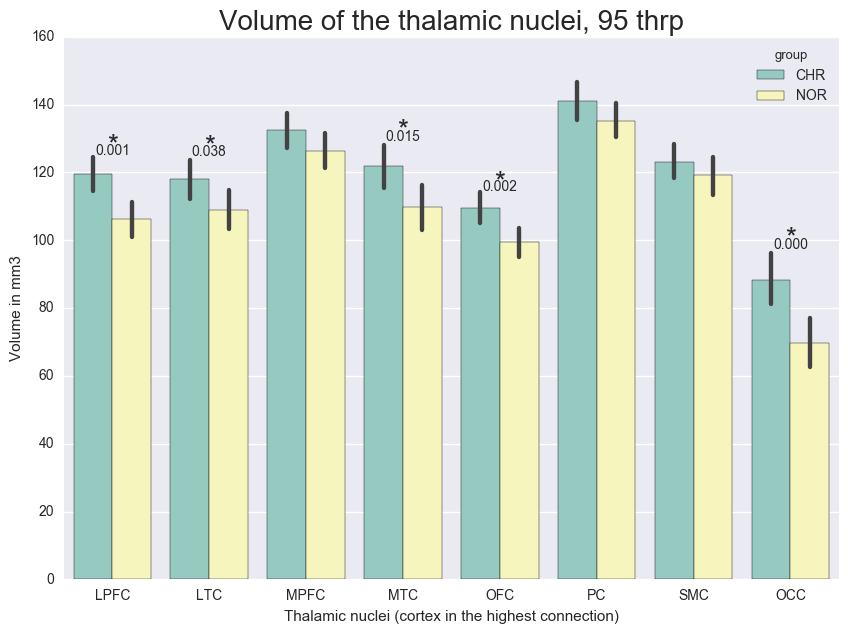

In [36]:
for thr in '10', '90', '95':
#     volume = 'Volume_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 'thalamus_seg_volume', 
                     hue='group', palette=sns.color_palette("Set3", 2),
                data=df_matched[['subject',
                                 'cortex',
                                 'thalamus_seg_volume',
                                 'group',
                                 'threshold']].drop_duplicates().groupby('threshold').get_group(thr))     

    ax.set_title('Volume of the thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Volume in mm3')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    
    
    compare = 'thalamus_seg_volume'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_matched[['subject',
                        'cortex',
                        'thalamus_seg_volume',
                        'age',
                        'sex',
                        'group',
                        'threshold']].drop_duplicates().groupby(['cortex','threshold']).get_group((cortex, thr))
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

In [37]:
df_matched.head()

subject  side cortex threshold  cortex_volume  thalamus_volume  \
0   CHR04  left   LPFC         5          30171            10032   
1   CHR04  left    LTC         5          47297            10032   
2   CHR04  left   MPFC         5          30242            10032   
3   CHR04  left    MTC         5          18015            10032   
4   CHR04  left    OFC         5          16580            10032   

   thalamus_seg_volume  thalamus_seg_mk  total_connectivity  \
0                  520         0.829182       229689.476292   
1                 1014         0.793938       148975.244996   
2                  908         0.767550       175404.579798   
3                 1028         0.781127       190459.817848   
4                  740         0.792501       553059.446961   

   total_connectivity_raw  relative_connectivity group folderName  sex  age  \
0               2932619.0               0.118277   CHR  CHR04_PJH    1   24   
1               1889038.0               0.076188   CHR  CHR04_PJH    1   24   
2               2253434.0               0.090885   CHR  CHR04_PJH    1   24   
3               2498761.0               0.100779   CHR  CHR04_PJH    1   24   
4               7005886.0               0.282559   CHR  CHR04_PJH    1   24   

   handedness  
0           1  
1           1  
2           1  
3           1  
4           1

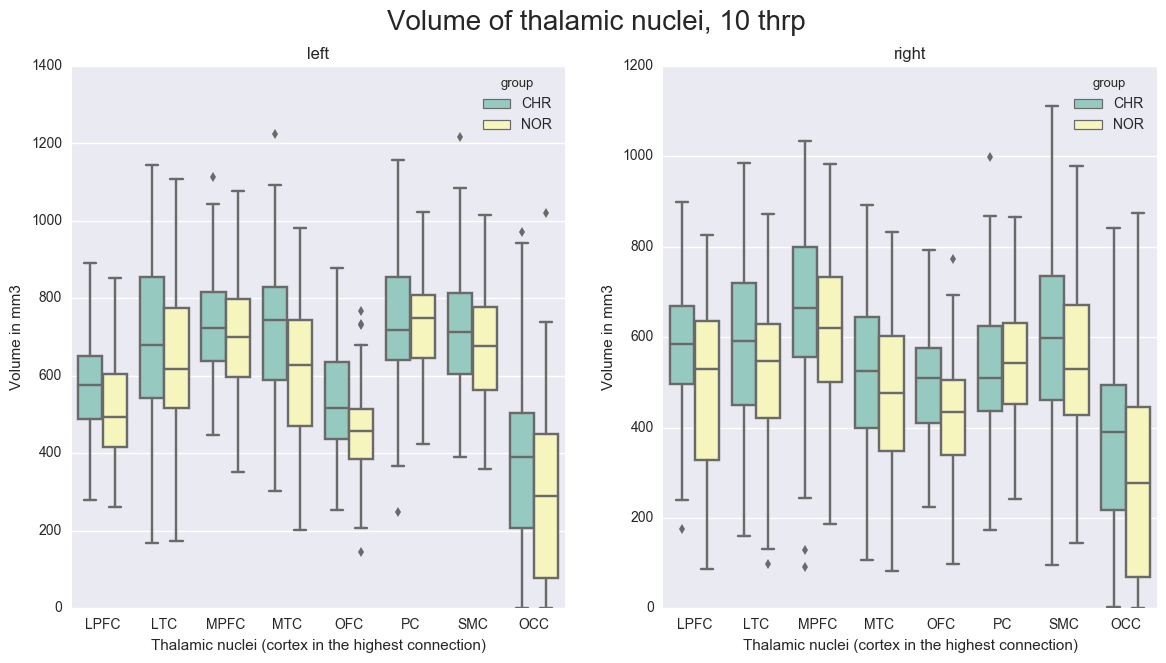

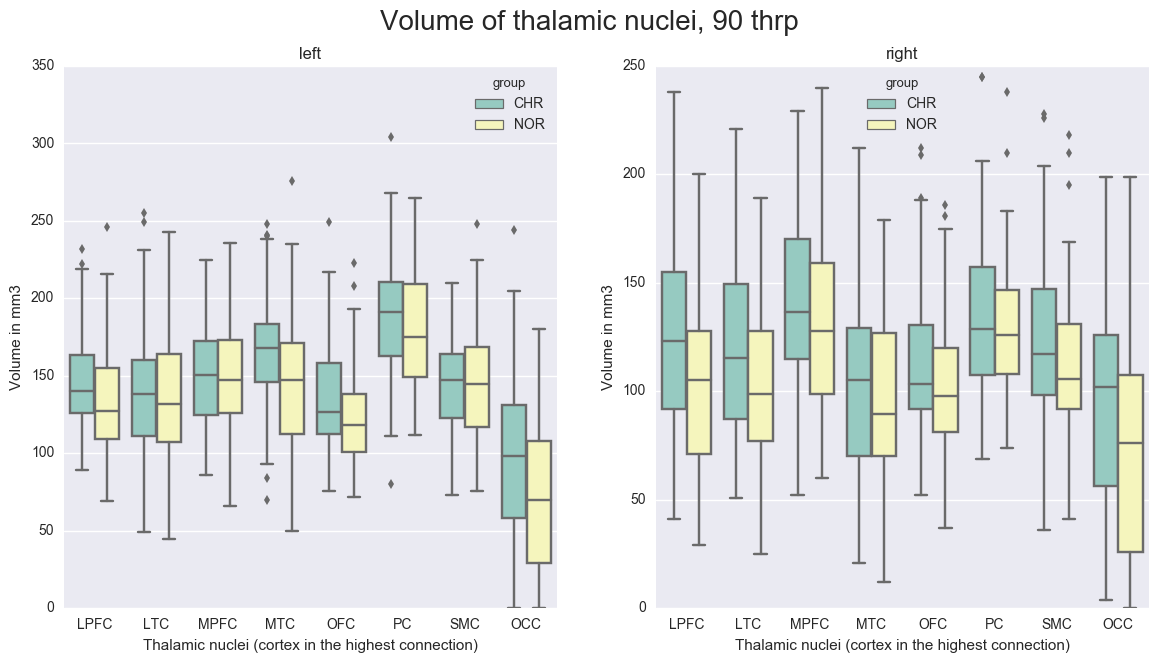

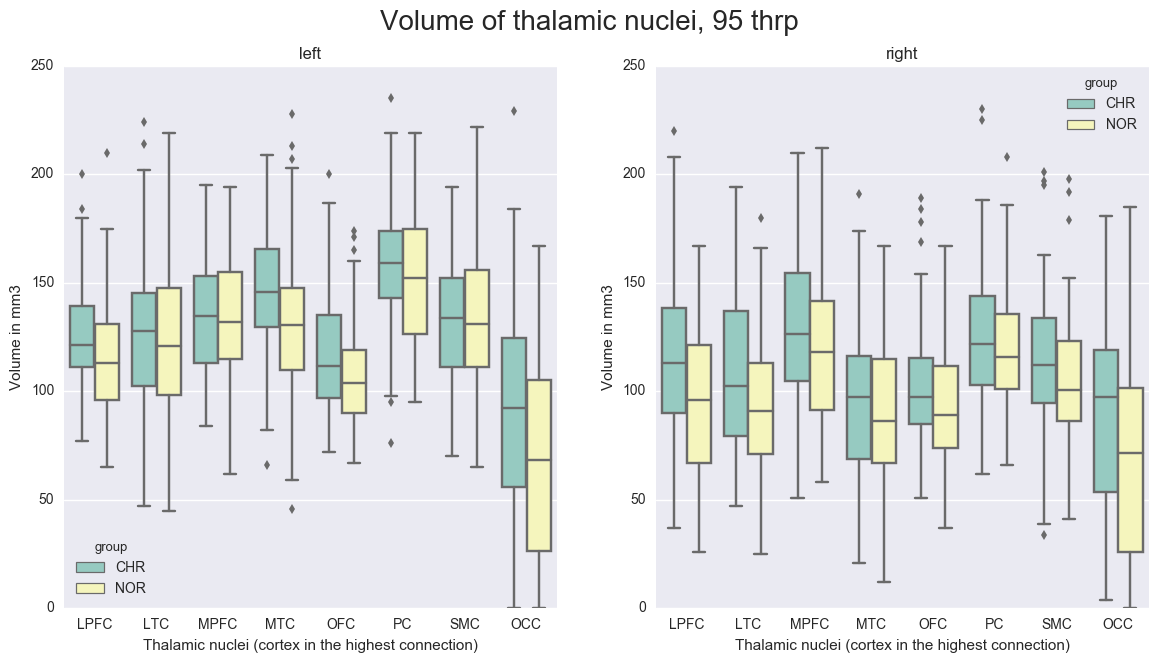

In [38]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    'thalamus_seg_volume',
                    hue='group', 
                    palette=sns.color_palette("Set3", 2),
                    data=df_matched[['subject','side','cortex','threshold','group',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)


    fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

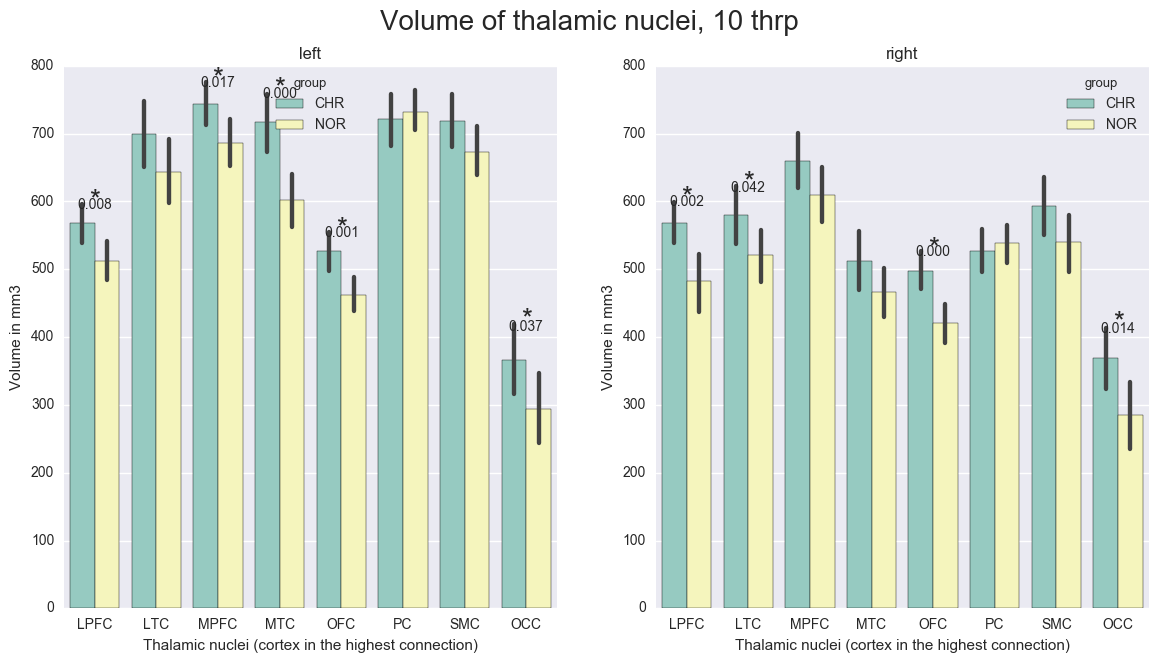

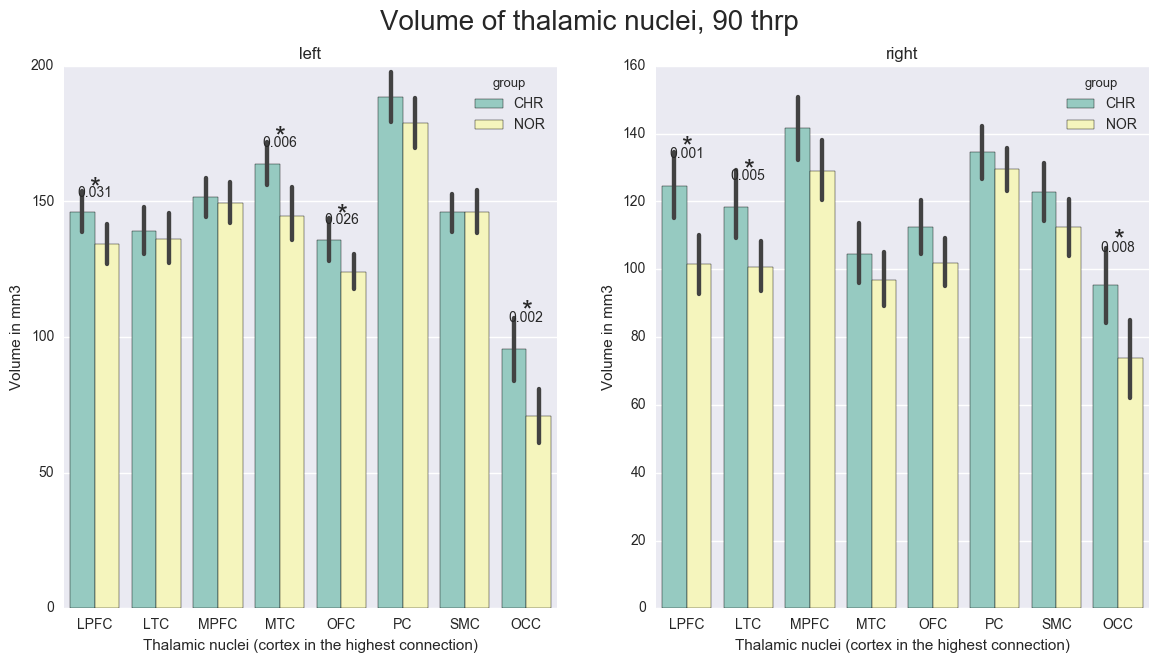

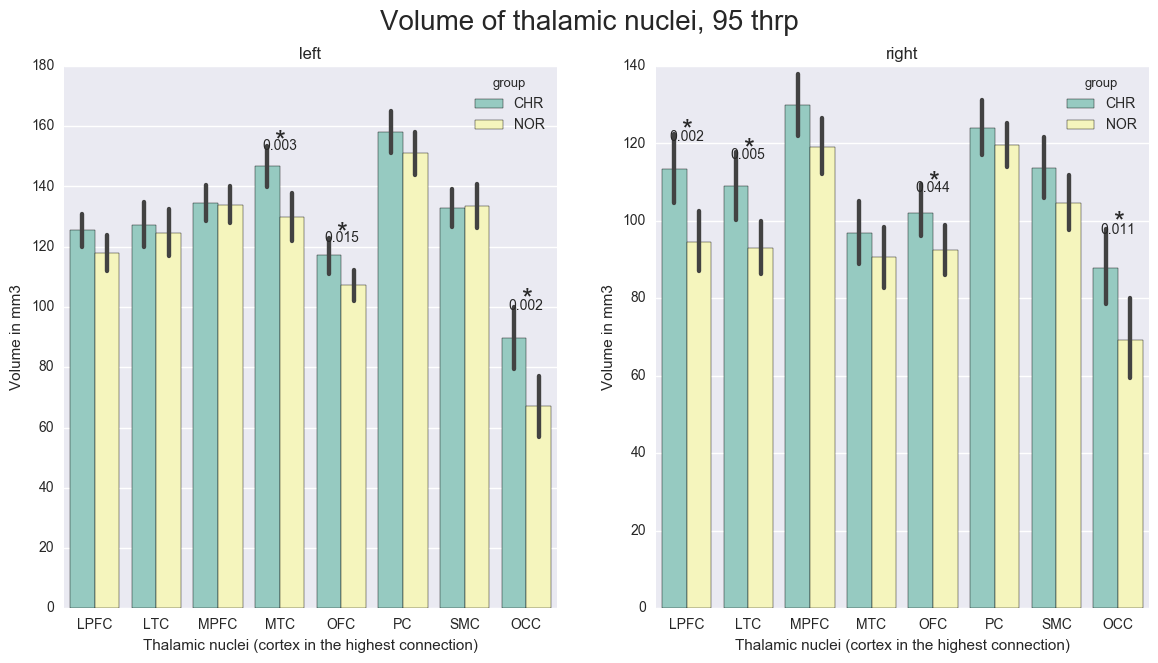

In [39]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'thalamus_seg_volume',
                    hue='group', 
                    palette=sns.color_palette("Set3", 2),
                    data=df_matched[['subject','side','cortex','threshold','group',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold']).get_group((side, thr)),
                    ax=axes[num])
        axes[num].set_ylabel('Volume in mm3')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

        compare = 'thalamus_seg_volume'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_matched[['subject','side','cortex','threshold','group','age','sex',
                                     'thalamus_seg_volume']].drop_duplicates().groupby(['side','threshold','cortex']).get_group((side, thr, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
        #         print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)

    fig.suptitle('Volume of thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

In [40]:
df_matched.head()

subject  side cortex threshold  cortex_volume  thalamus_volume  \
0   CHR04  left   LPFC         5          30171            10032   
1   CHR04  left    LTC         5          47297            10032   
2   CHR04  left   MPFC         5          30242            10032   
3   CHR04  left    MTC         5          18015            10032   
4   CHR04  left    OFC         5          16580            10032   

   thalamus_seg_volume  thalamus_seg_mk  total_connectivity  \
0                  520         0.829182       229689.476292   
1                 1014         0.793938       148975.244996   
2                  908         0.767550       175404.579798   
3                 1028         0.781127       190459.817848   
4                  740         0.792501       553059.446961   

   total_connectivity_raw  relative_connectivity group folderName  sex  age  \
0               2932619.0               0.118277   CHR  CHR04_PJH    1   24   
1               1889038.0               0.076188   CHR  CHR04_PJH    1   24   
2               2253434.0               0.090885   CHR  CHR04_PJH    1   24   
3               2498761.0               0.100779   CHR  CHR04_PJH    1   24   
4               7005886.0               0.282559   CHR  CHR04_PJH    1   24   

   handedness  
0           1  
1           1  
2           1  
3           1  
4           1

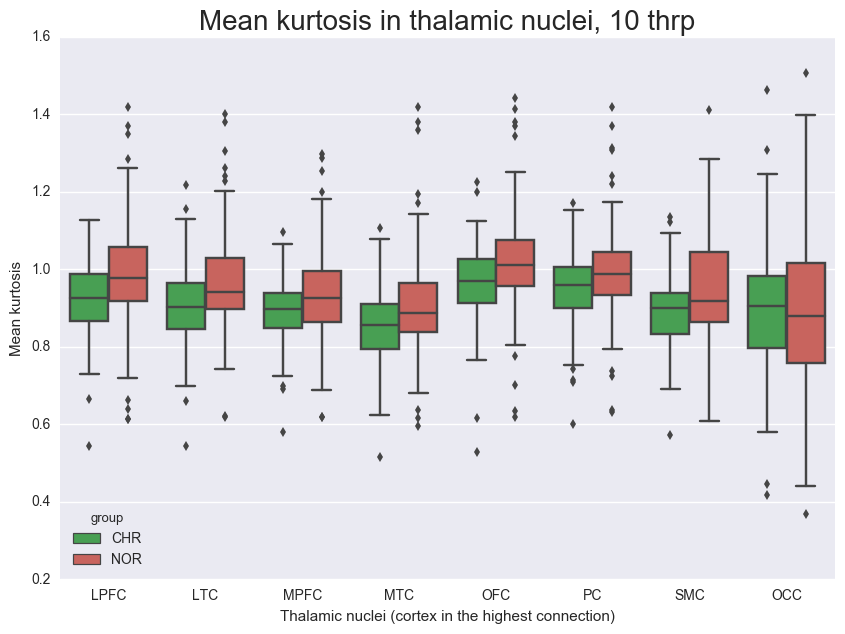

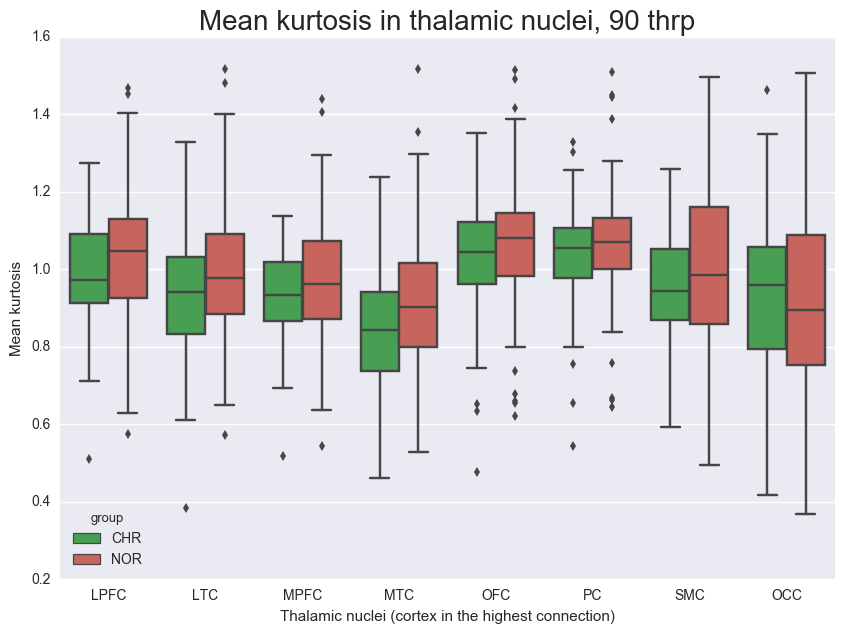

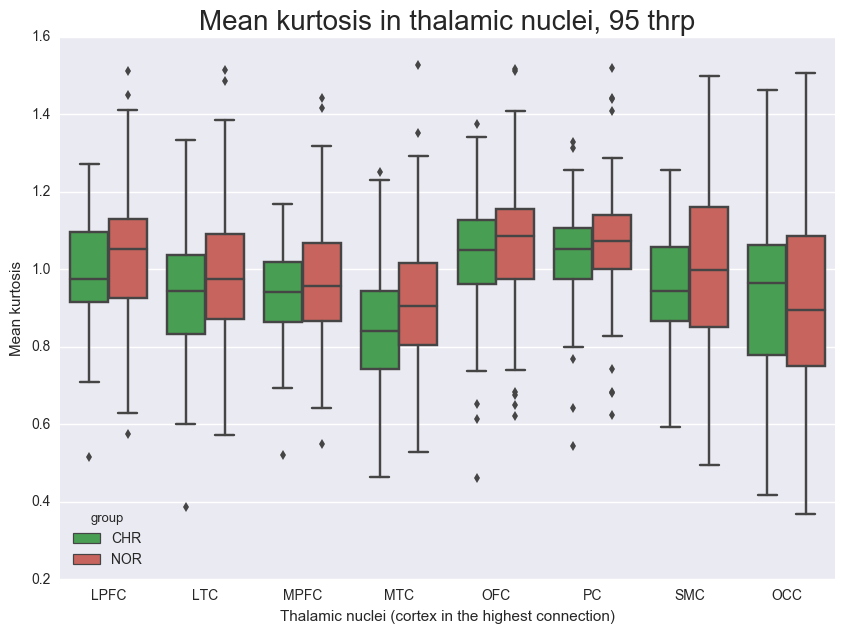

In [41]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    ax = plt.figure(figsize=(10,7))
    ax = sns.boxplot('cortex',
                     'thalamus_seg_mk',
                     hue='group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data = df_gb.get_group(thr))     

    ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    ax.set_xlabel('Thalamic nuclei (cortex in the highest connection)')
    plt.show()

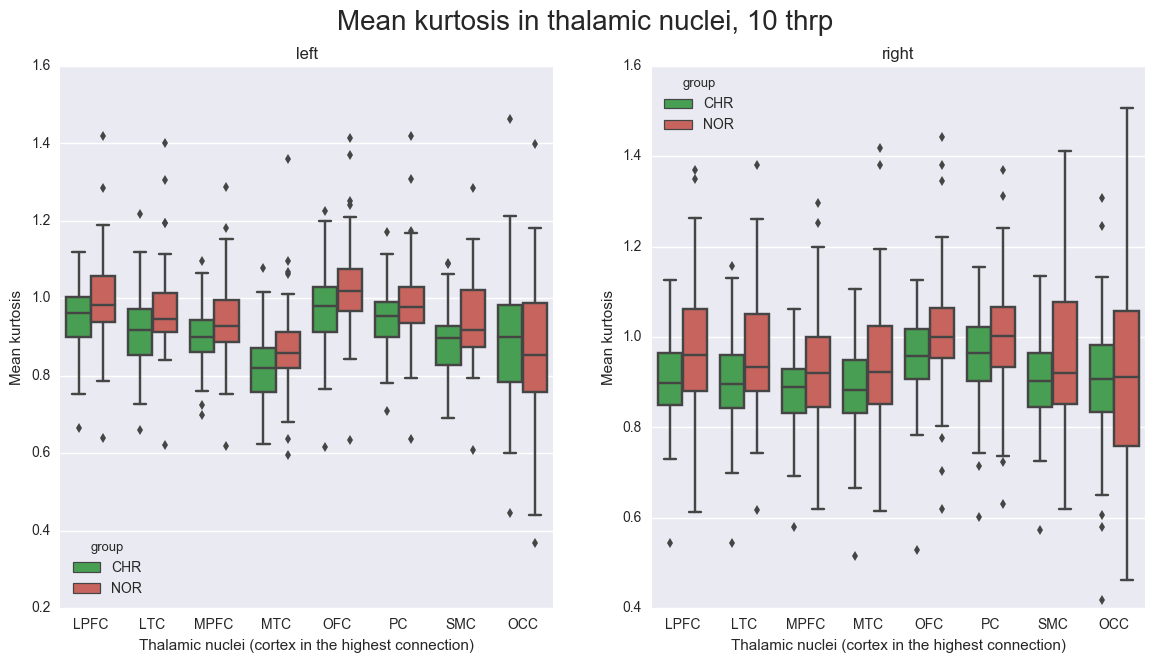

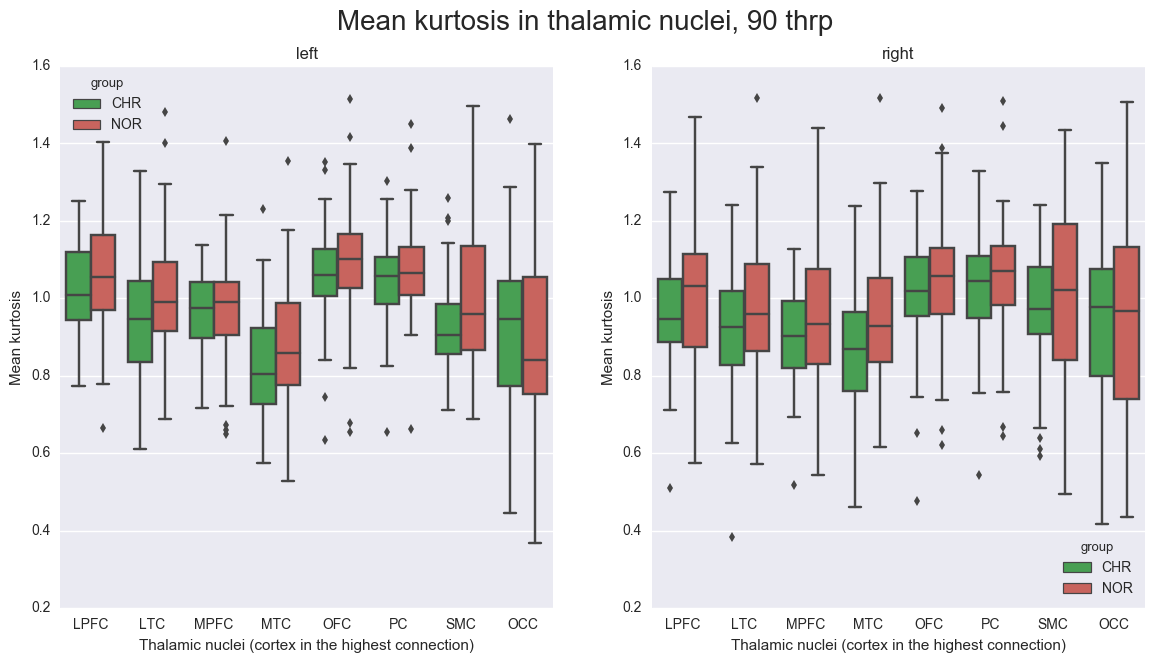

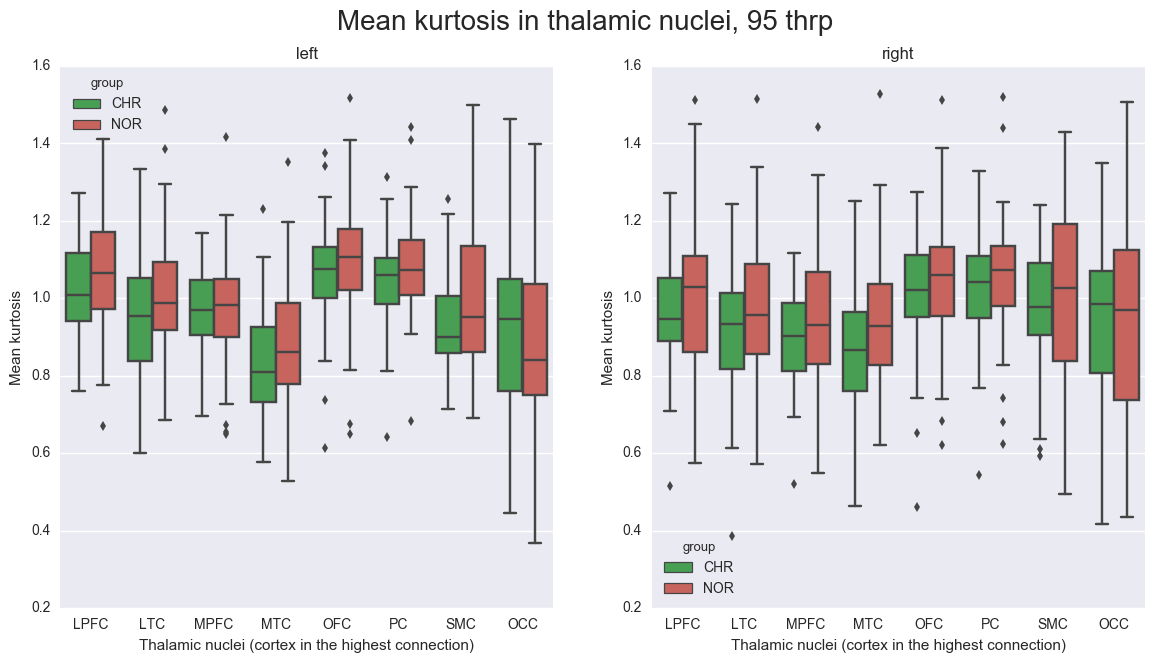

In [42]:
df_gb = df_matched.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.boxplot('cortex', 
                    'thalamus_seg_mk',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        

    fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

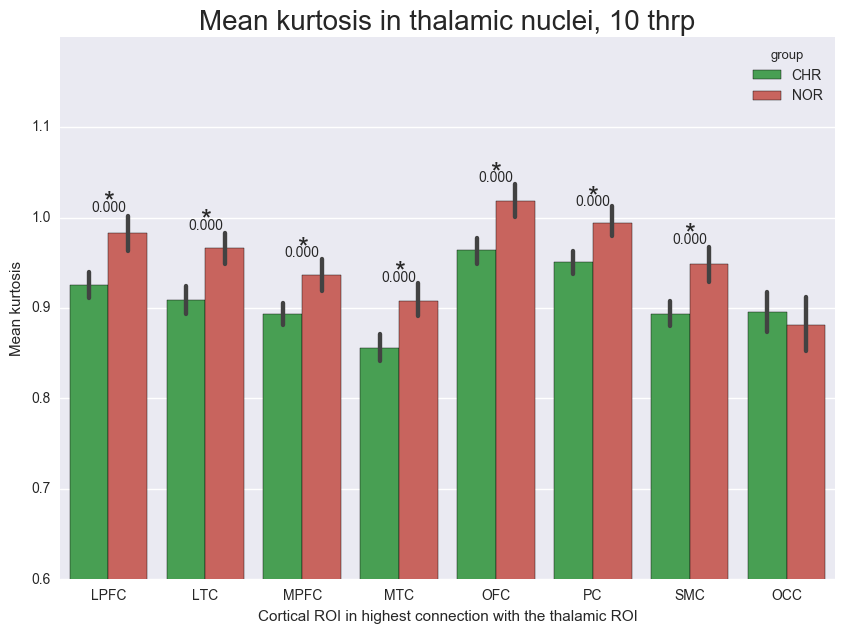

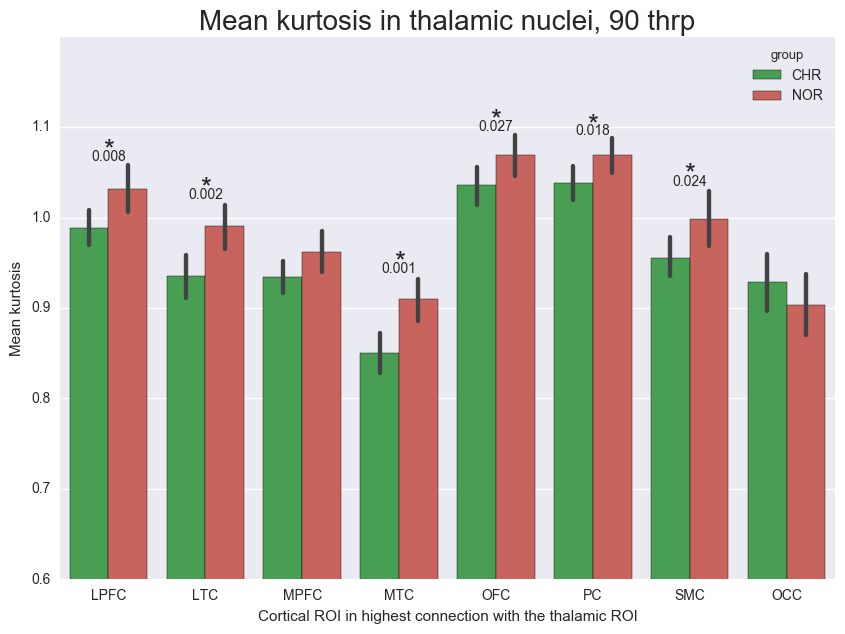

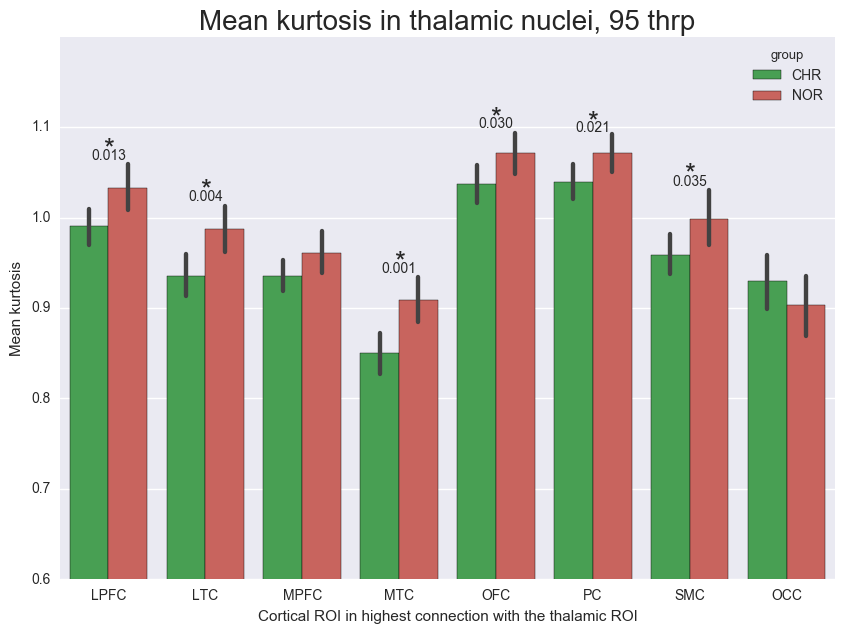

In [43]:
df_gb = df_matched.groupby('threshold')

for thr in '10', '90', '95':
    mk = 'mk_'+thr
    ax = plt.figure(figsize=(10,7))
    ax = sns.barplot('cortex', 
                     'thalamus_seg_mk', 
                     hue='group', 
                     palette=sns.xkcd_palette(['medium green','pale red']),
                     data=df_gb.get_group(thr))     
    ax.set_ylim(0.6, 1.2)
    ax.set_title('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    ax.set_ylabel('Mean kurtosis')
    ax.set_xlabel('Cortical ROI in highest connection with the thalamic ROI')
    
    compare = 'thalamus_seg_mk'
    for num, cortex in enumerate(df_matched.cortex.unique()):
        x = df_gb.get_group(thr).groupby('cortex').get_group(cortex)
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:

    #         print(output)
            gb = x.groupby('group')

            if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
            else:
                group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

            conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('*', xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=20)

            conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
            ax.annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), xy=(num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    #         print(conf_int_a)
    #         ax.annotate("*", 
    #                     xy=(num, conf_int_a[1]), 
    #                     va='center', ha='center', fontsize=20)

    plt.show()

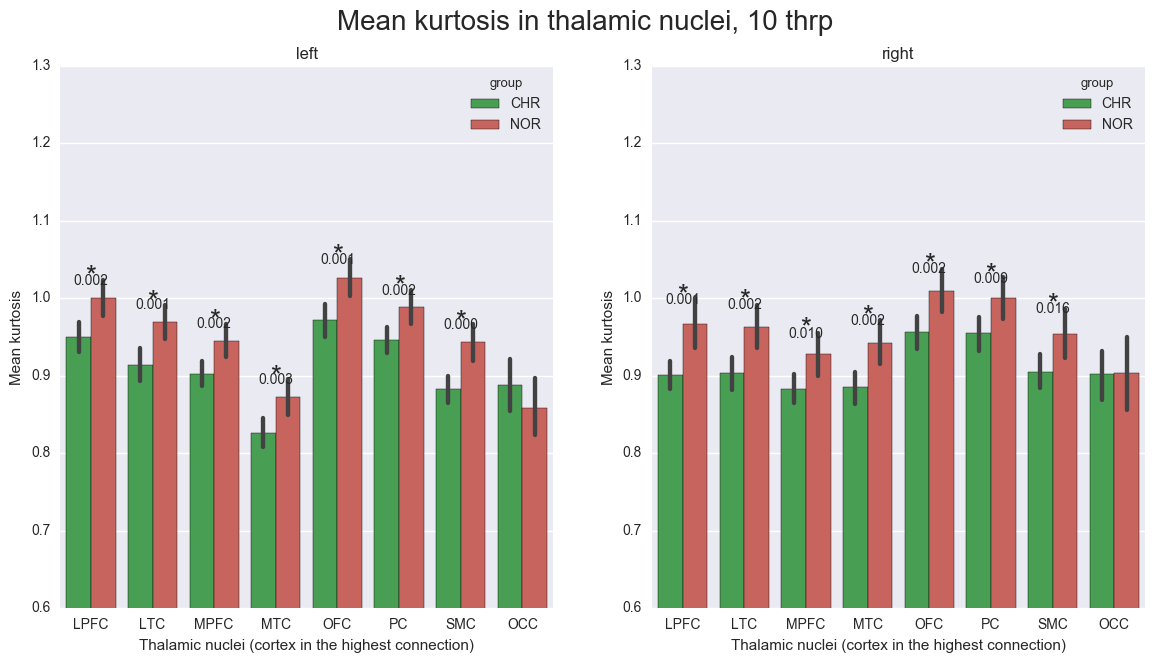

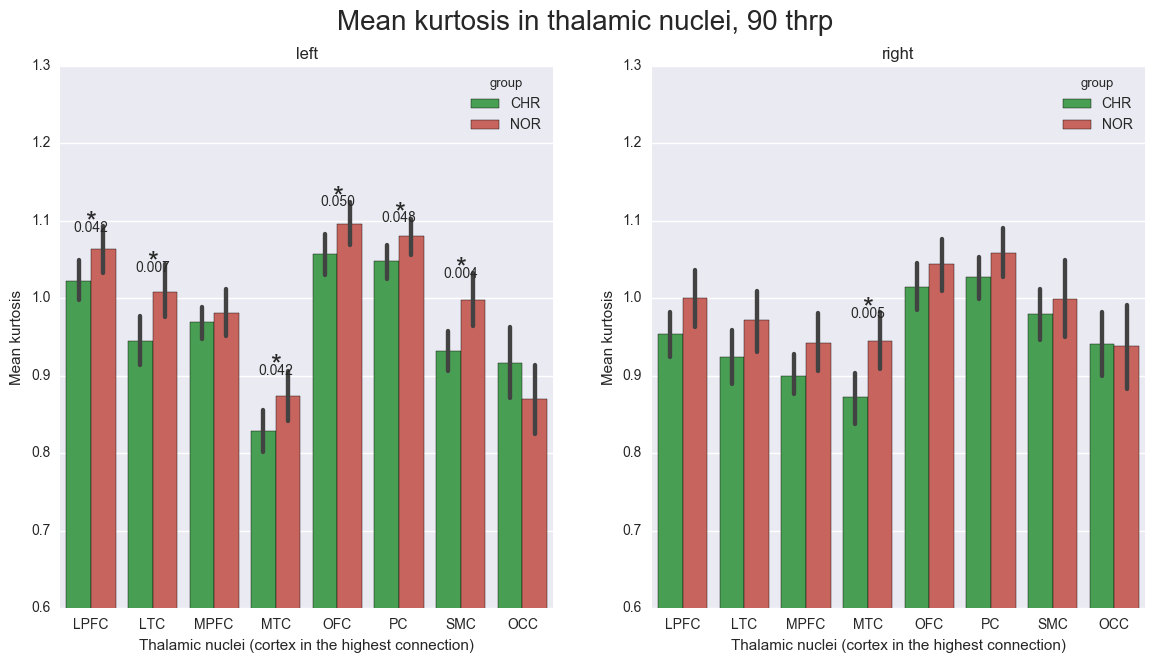

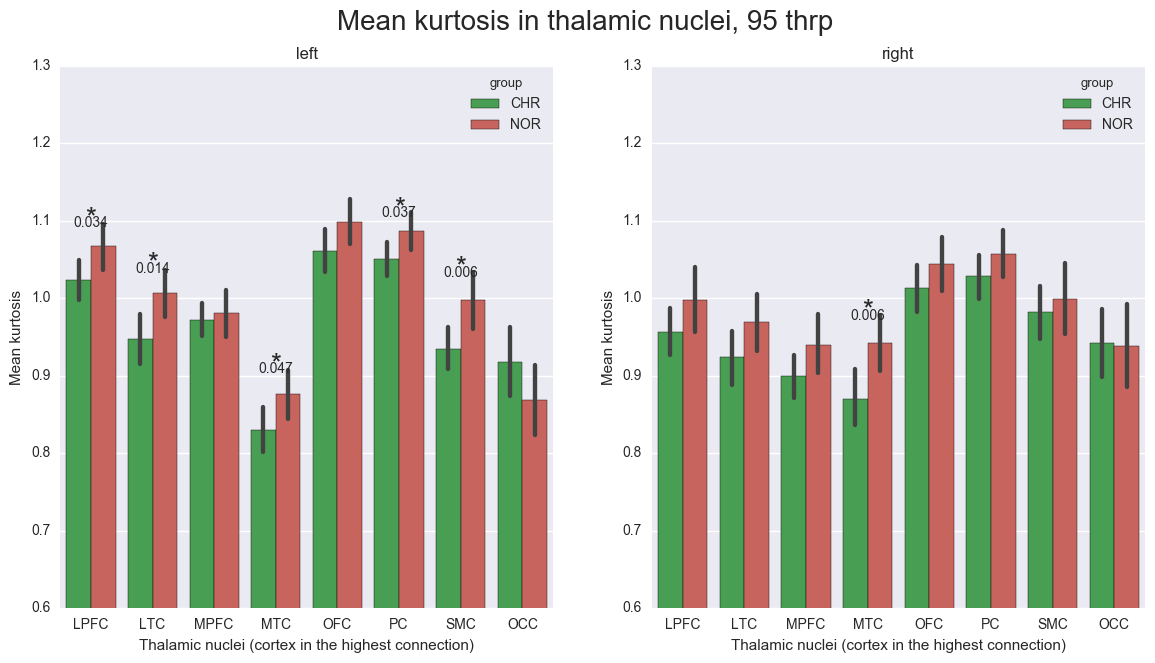

In [45]:
df_gb = df_matched.groupby(['threshold', 'side'])

for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'thalamus_seg_mk',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Mean kurtosis')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
        axes[num].set_ylim(0.6, 1.3)

        compare = 'thalamus_seg_mk'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)÷
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle('Mean kurtosis in thalamic nuclei, {0} thrp'.format(thr), fontsize=20)
    plt.show()

In [61]:
df_matched.head()

subject  side cortex threshold  cortex_volume  thalamus_volume  \
0   CHR04  left   LPFC         5          30171            10032   
1   CHR04  left    LTC         5          47297            10032   
2   CHR04  left   MPFC         5          30242            10032   
3   CHR04  left    MTC         5          18015            10032   
4   CHR04  left    OFC         5          16580            10032   

   thalamus_seg_volume  thalamus_seg_mk  total_connectivity  \
0                  520         0.829182       229689.476292   
1                 1014         0.793938       148975.244996   
2                  908         0.767550       175404.579798   
3                 1028         0.781127       190459.817848   
4                  740         0.792501       553059.446961   

   total_connectivity_raw  relative_connectivity group folderName  sex  age  \
0                 2932619               0.118277   CHR  CHR04_PJH    1   24   
1                 1889038               0.076188   CHR  CHR04_PJH    1   24   
2                 2253434               0.090885   CHR  CHR04_PJH    1   24   
3                 2498761               0.100779   CHR  CHR04_PJH    1   24   
4                 7005886               0.282559   CHR  CHR04_PJH    1   24   

   handedness  
0           1  
1           1  
2           1  
3           1  
4           1

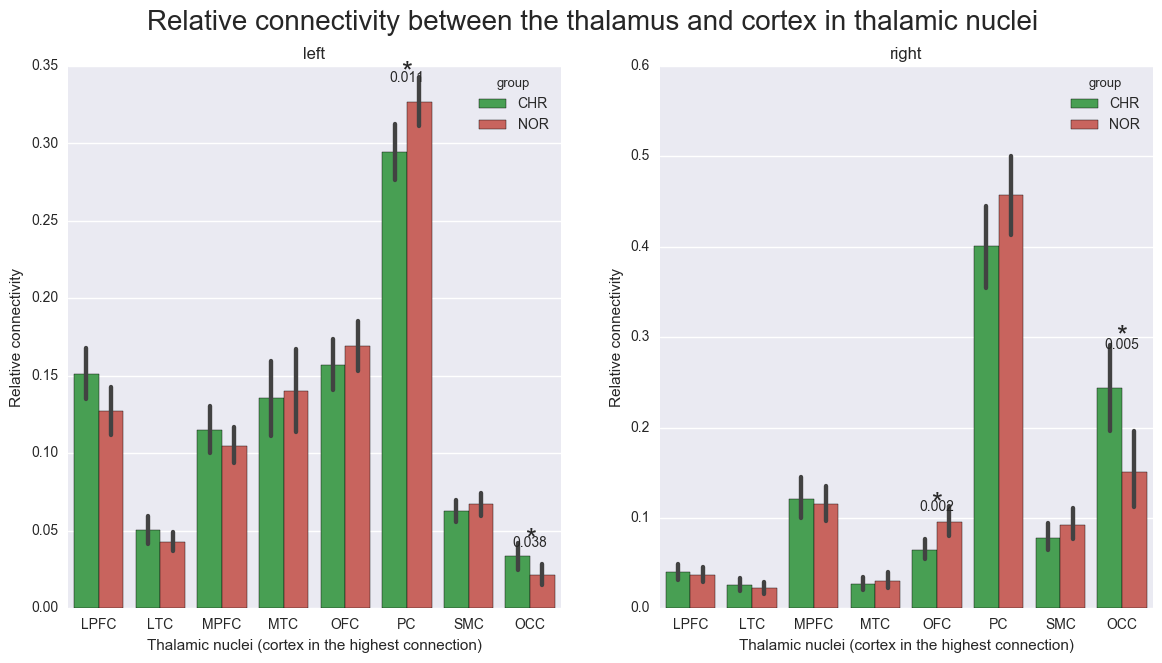

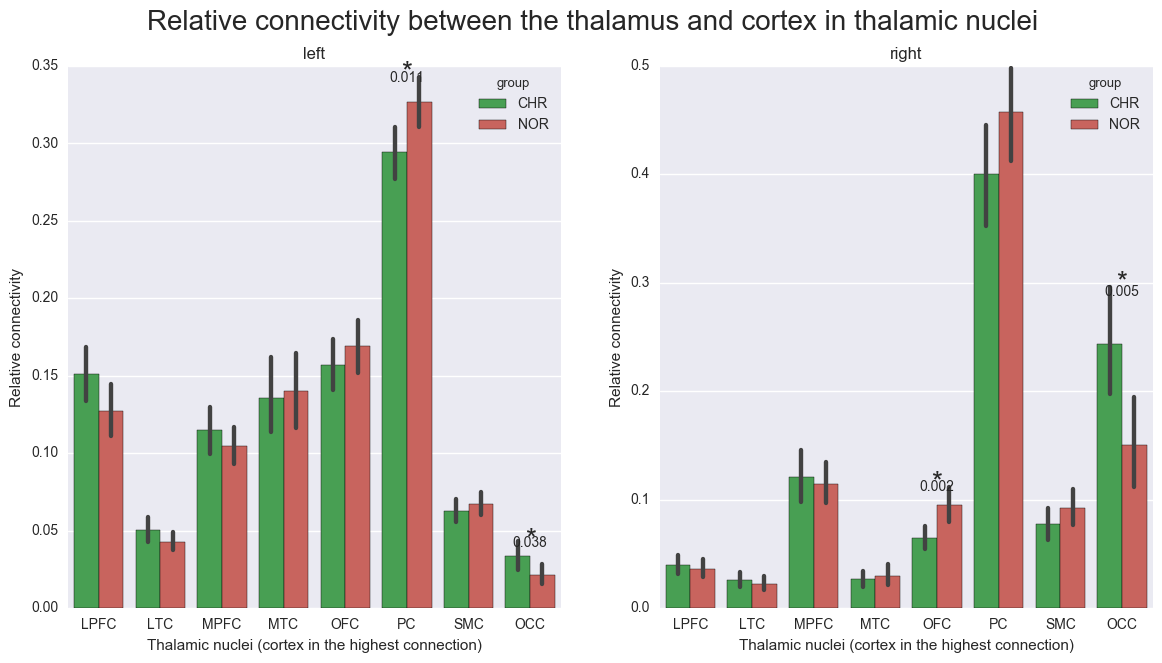

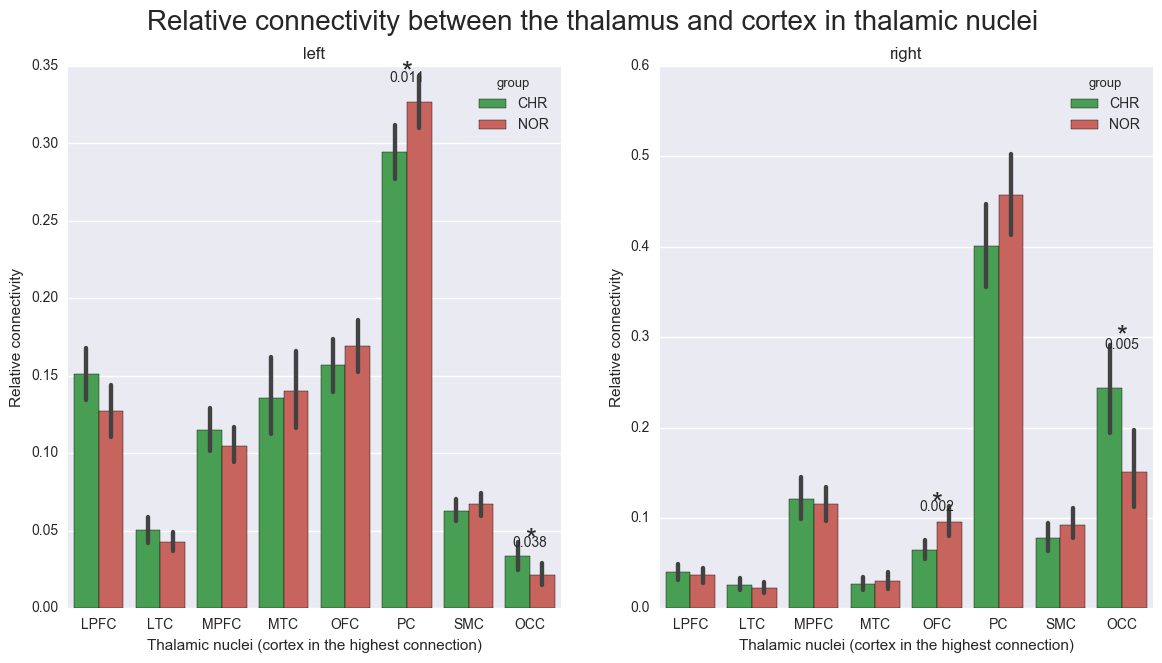

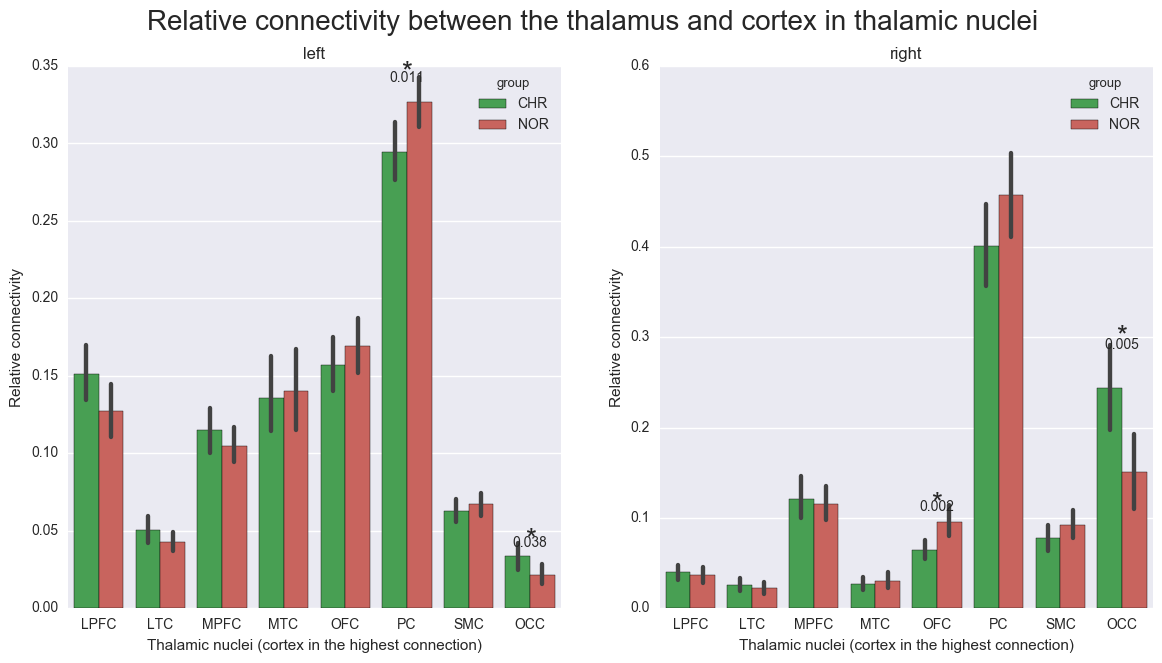

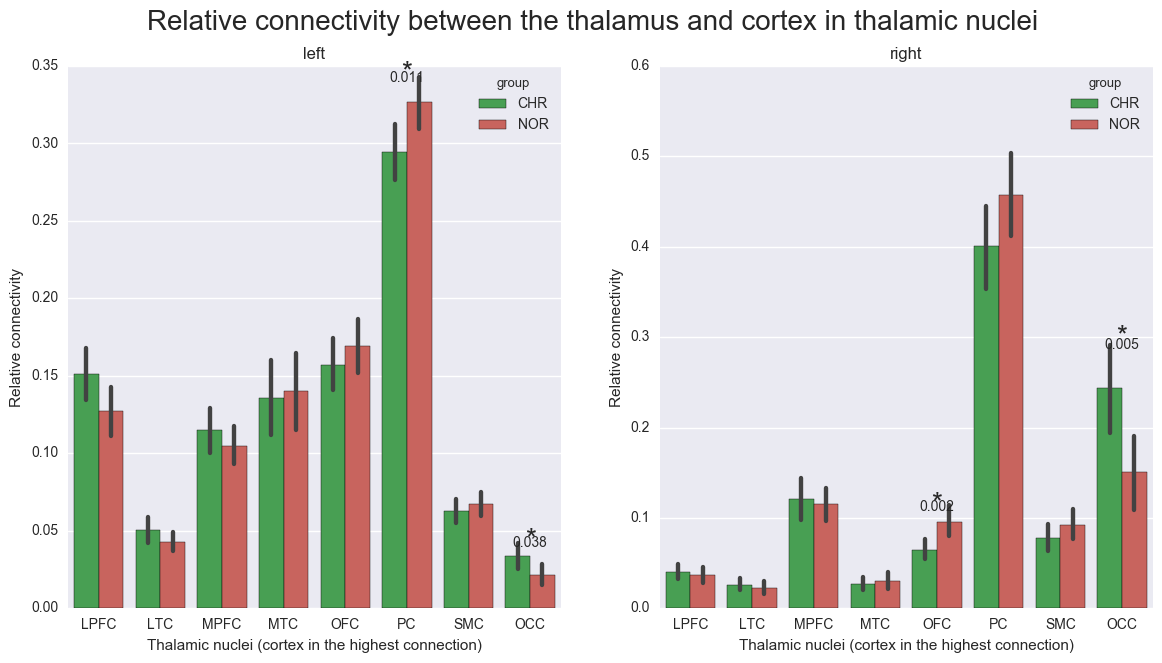

In [46]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'relative_connectivity',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Relative connectivity')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'relative_connectivity'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
    #                 print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle('Relative connectivity between the thalamus and cortex in thalamic nuclei'.format(thr), fontsize=20)
    plt.show()

In [50]:
df_matched.groupby('threshold').mean()

cortex_volume  thalamus_volume  thalamus_seg_volume  \
threshold                                                        
10           32180.25974      8844.792208           557.131494   
20           32180.25974      8844.792208           427.899351   
5            32180.25974      8844.792208           674.394886   
90           32180.25974      8844.792208           126.556006   
95           32180.25974      8844.792208           114.212662   

           thalamus_seg_mk  total_connectivity  total_connectivity_raw  \
threshold                                                                
10                0.932954       119162.996835            1.607790e+06   
20                0.947040       107969.415651            1.607790e+06   
5                 0.919860       125034.620983            1.607790e+06   
90                0.975399        29890.028295            1.607790e+06   
95                0.976090        24713.647244            1.607790e+06   

           relative_connectivity       sex        age  handedness  
threshold                                                          
10                         0.125  1.305195  21.714286    1.077922  
20                         0.125  1.305195  21.714286    1.077922  
5                          0.125  1.305195  21.714286    1.077922  
90                         0.125  1.305195  21.714286    1.077922  
95                         0.125  1.305195  21.714286    1.077922

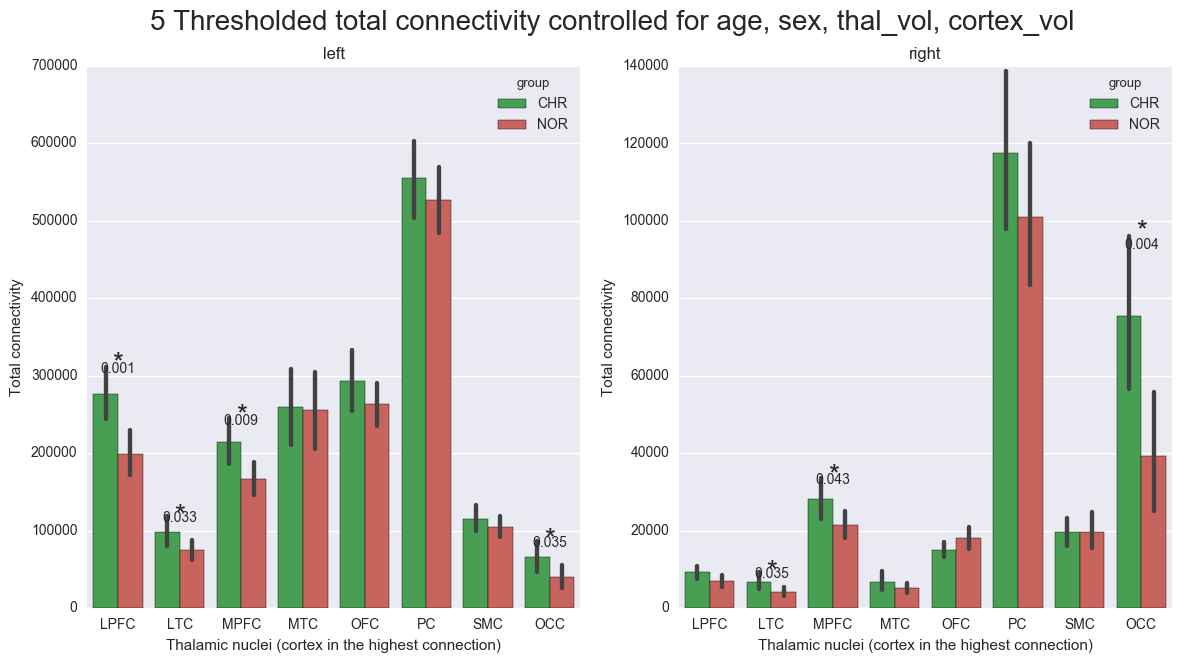

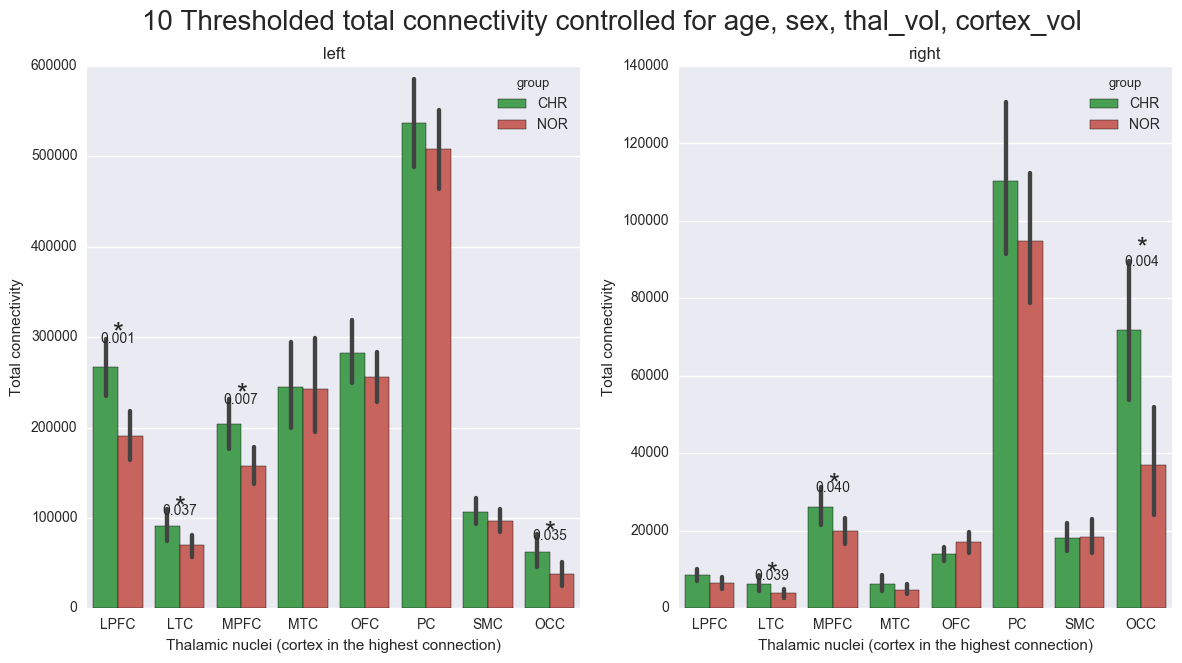

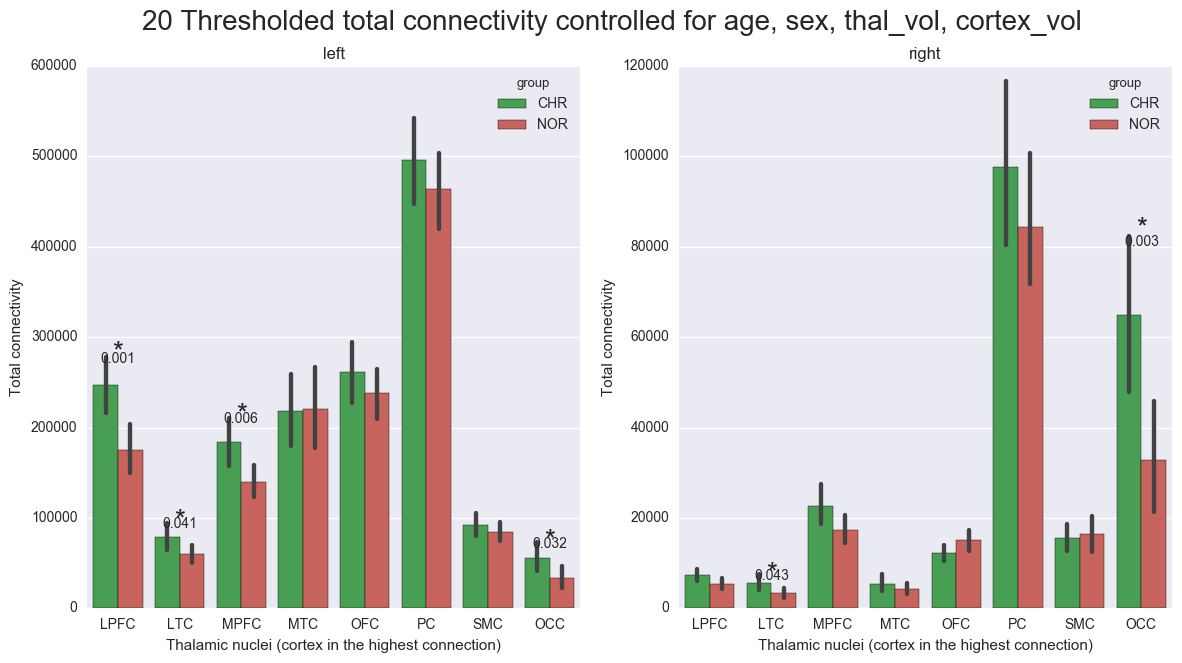

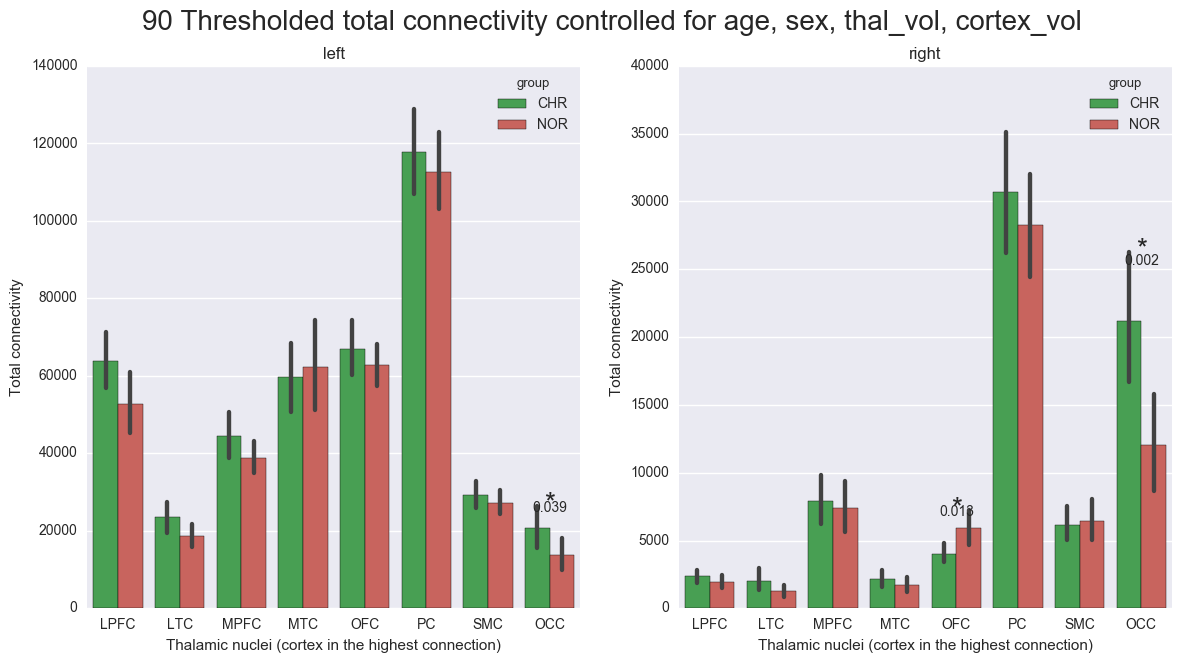

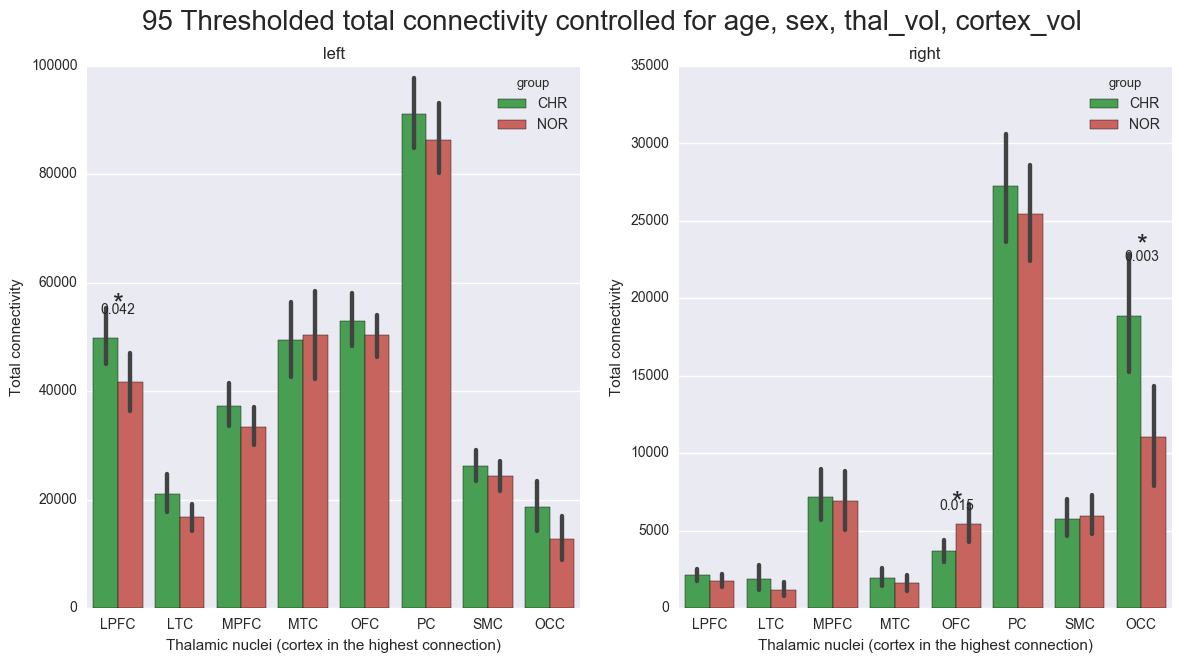

In [53]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'total_connectivity',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Total connectivity')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'total_connectivity'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            THAL_VOL = x['thalamus_volume']
            CORTEX_VOL = x['cortex_volume']
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle(thr+' Thresholded total connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
    plt.show()

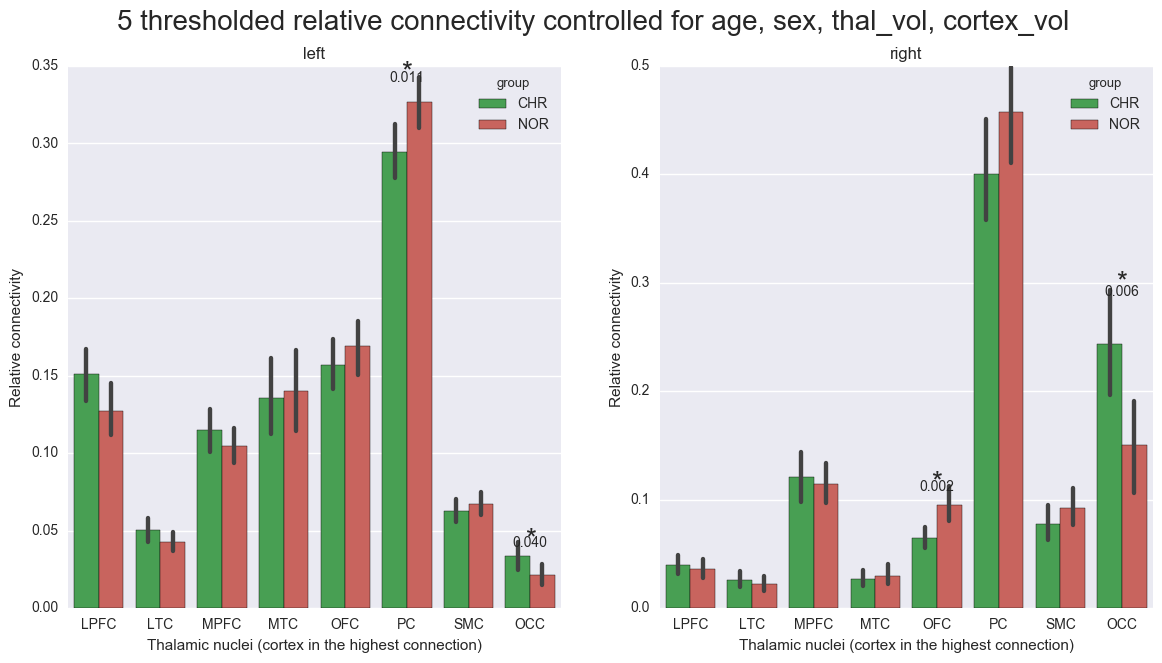

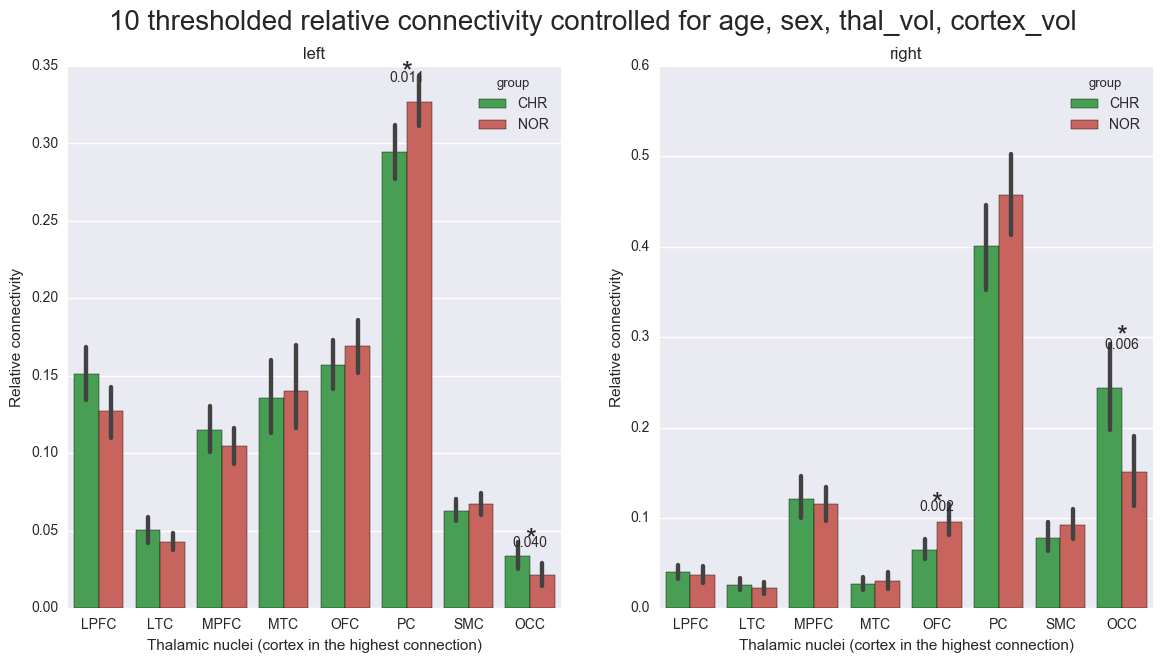

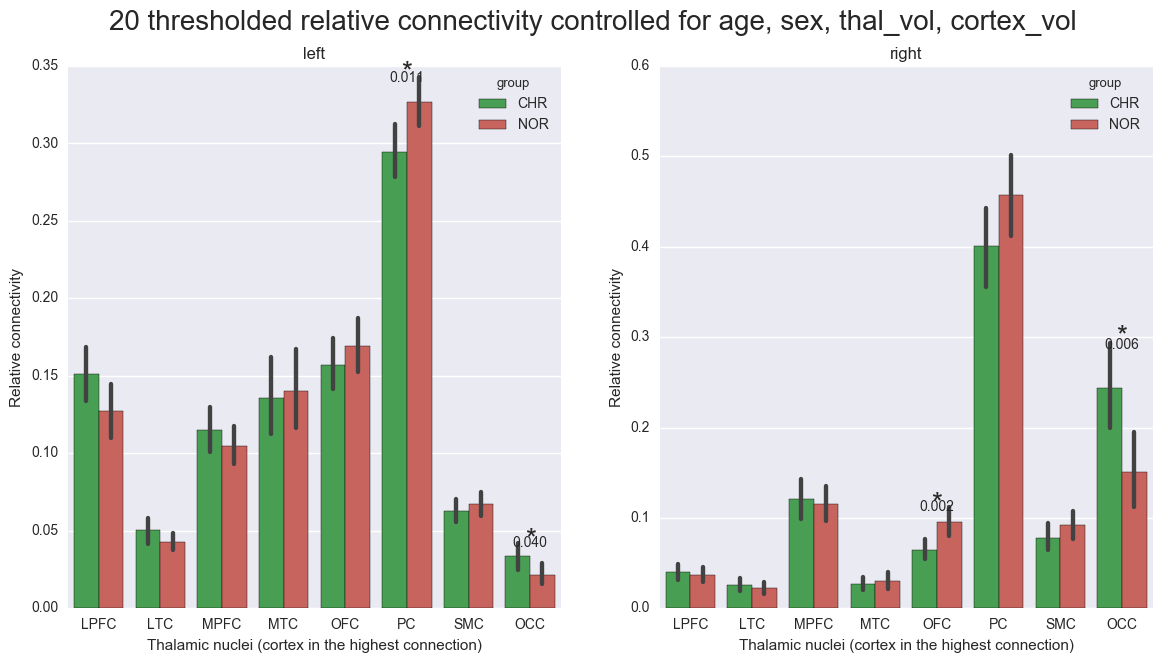

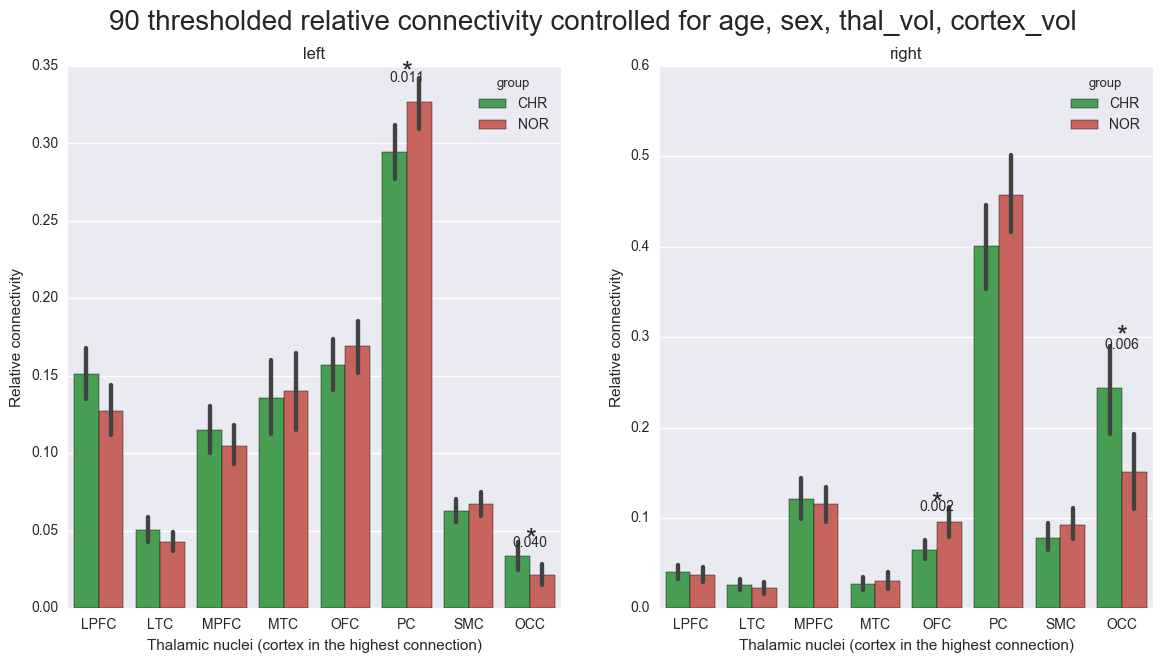

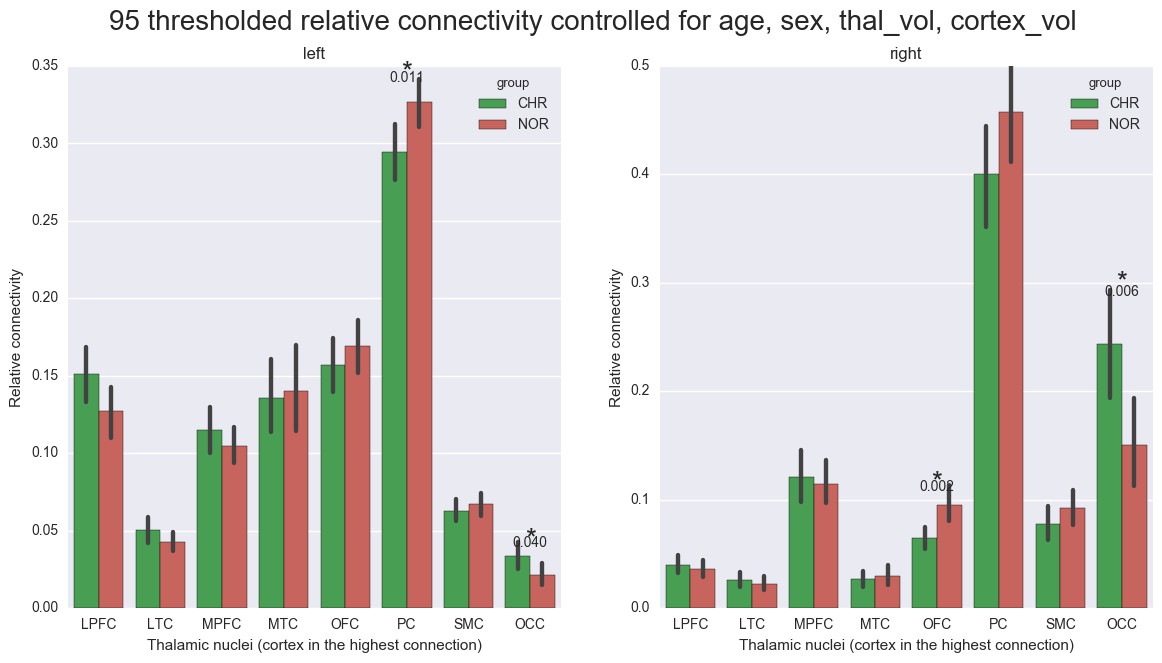

In [54]:
df_gb = df_matched.groupby(['threshold', 'side'])
# Arbitrary value
# thr = '10'
for thr in '5','10','20','90','95':
    fig, axes = plt.subplots(ncols=2, figsize=(14,7))
    for num, side in enumerate(['left', 'right']):
        sns.barplot('cortex', 
                    'relative_connectivity',
                    hue='group', 
                    palette=sns.xkcd_palette(['medium green','pale red']),
                    data=df_gb.get_group((thr, side)),
                    ax=axes[num])
        axes[num].set_ylabel('Relative connectivity')
        axes[num].set_xlabel('Thalamic nuclei (cortex in the highest connection)')
        axes[num].set_title(side)
    #         axes[num].set_ylim(0.6, 1.3)

        compare = 'relative_connectivity'
        for roi_num, cortex in enumerate(df_matched.cortex.unique()):
            x = df_gb.get_group((thr,side)).groupby('cortex').get_group(cortex)
            GROUP = x['group']
            VAR = x[compare]
            THAL_VOL = x['thalamus_volume']
            CORTEX_VOL = x['cortex_volume']
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX + THAL_VOL + CORTEX_VOL'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
#                 print(output)
                gb = x.groupby('group')

                if gb.get_group(list(gb.groups.keys())[0])[compare].mean() > gb.get_group(list(gb.groups.keys())[1])[compare].mean():
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[0])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[0])[compare].std()
                else:
                    group_mean_upper = gb.get_group(list(gb.groups.keys())[1])[compare].mean()
                    group_std_upper = gb.get_group(list(gb.groups.keys())[1])[compare].std()

                conf_int_a = stats.norm.interval(0.2, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('*', 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=20)

                conf_int_a = stats.norm.interval(0.17, loc=group_mean_upper, scale=group_std_upper)
                axes[num].annotate('{0:.3f}'.format(output['PR(>F)'].GROUP), 
                                   xy=(roi_num, conf_int_a[1]), va='center', ha='center', fontsize=10)
    fig.suptitle(thr+' thresholded relative connectivity controlled for age, sex, thal_vol, cortex_vol', fontsize=20)
    plt.show()

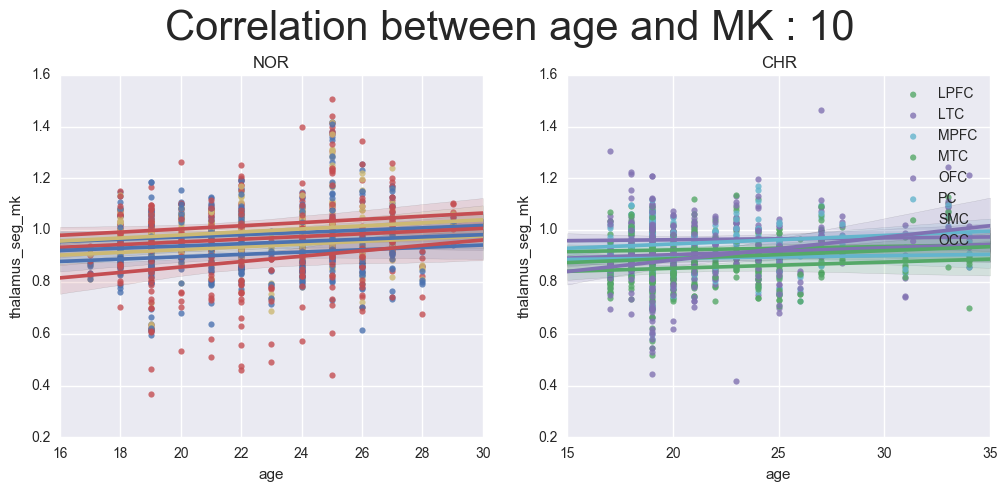

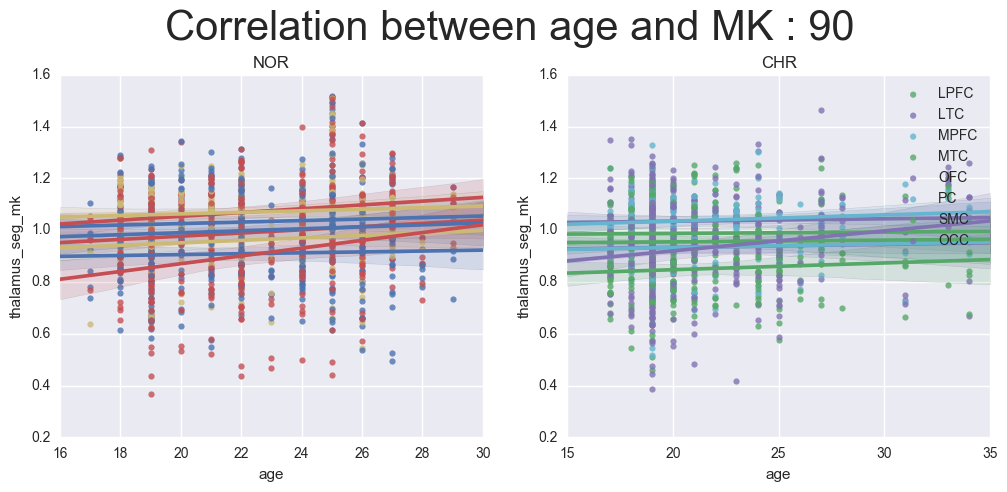

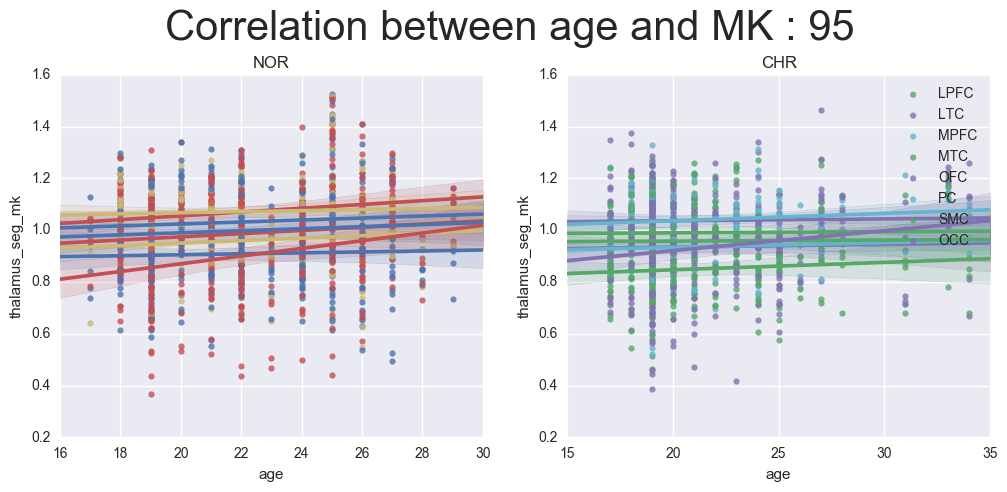

In [55]:
df_gb = df_matched.groupby(['group','cortex','threshold'])
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    for cortex in df_matched.cortex.unique():
        sns.regplot('age', 
                    'thalamus_seg_mk',
                    df_gb.get_group(('NOR', cortex, thr)),
                    label = cortex,
                    ax=axes[0])
        sns.regplot('age', 
                    'thalamus_seg_mk',
                    df_gb.get_group(('CHR', cortex, thr)),
                    label = cortex,
                    ax=axes[1])
    plt.subplots_adjust(top=0.85)
    axes[0].set_title('NOR')
    axes[1].set_title('CHR')
    fig.suptitle('Correlation between age and MK : {0}'.format(thr), fontsize=30)
    plt.legend()
    plt.show()

Correlation between age and MK : 10


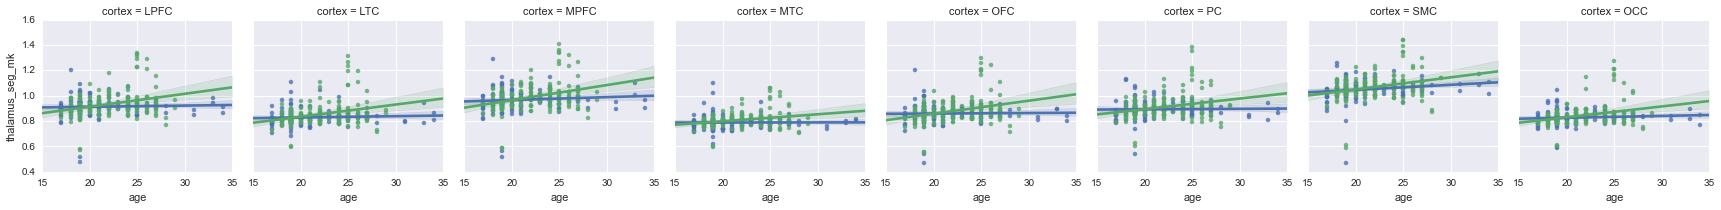

Correlation between age and MK : 90


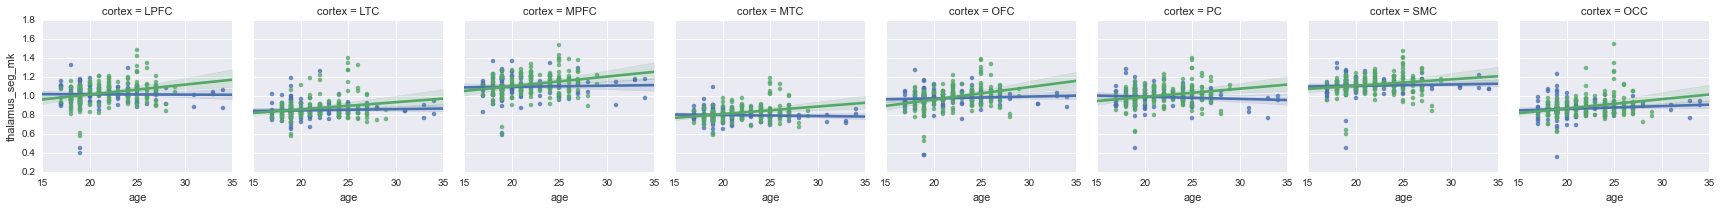

Correlation between age and MK : 95


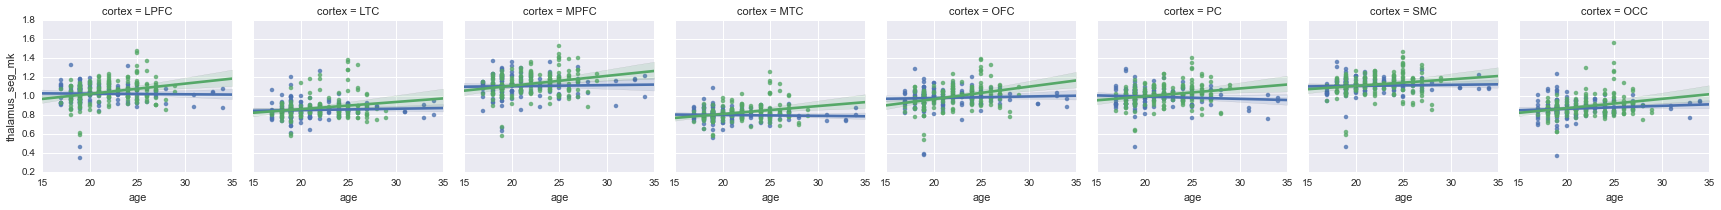

In [120]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), col='cortex', hue='group')
    g = g.map(sns.regplot, 'age','thalamus_seg_mk')
    print('Correlation between age and MK : '+thr)
    plt.show()

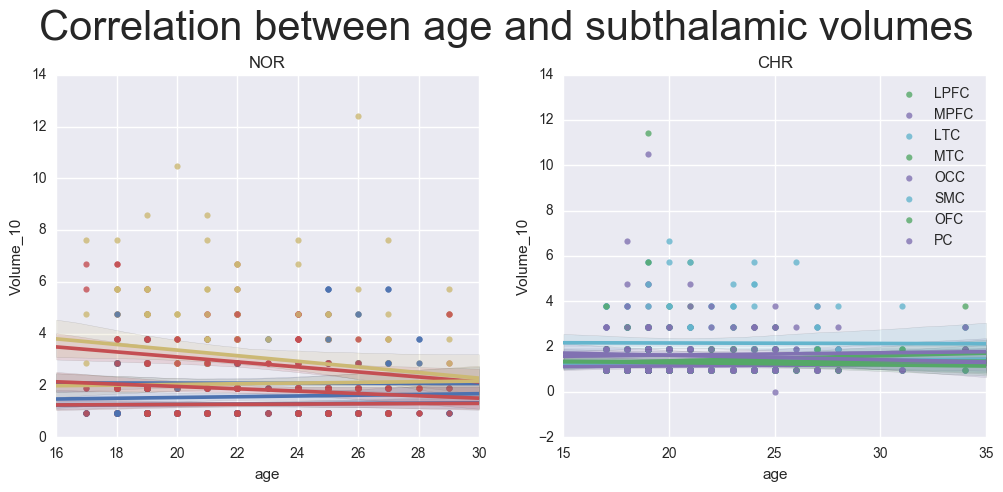

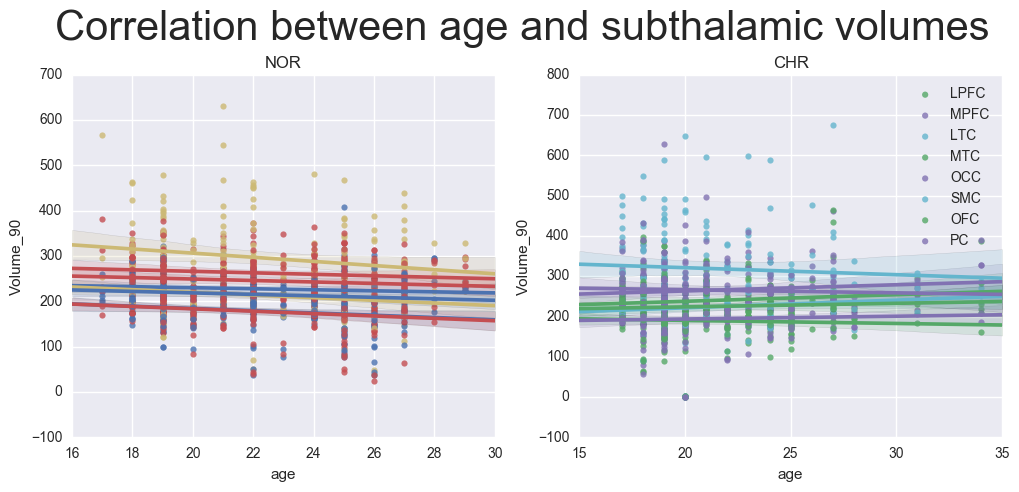

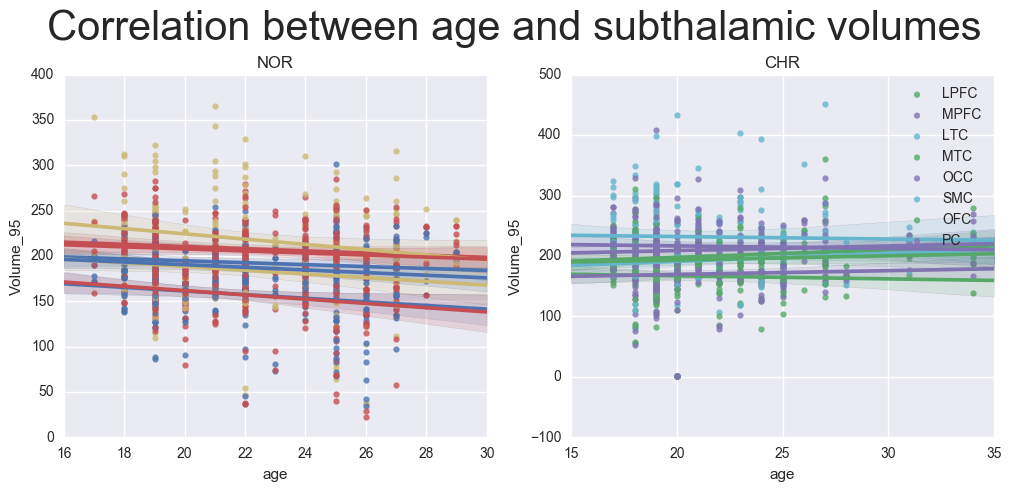

In [170]:
for thr in '10', '90', '95':
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    for roi in df_matched.roi.unique():
        sns.regplot('age', 
                    'Volume_'+thr, 
                    df_matched.groupby('Group').get_group('NOR').groupby('roi').get_group(roi),
                    label = roi,
                    ax=axes[0])
        sns.regplot('age', 
                    'Volume_'+thr, 
                    df_matched.groupby('Group').get_group('CHR').groupby('roi').get_group(roi),
                    label = roi,
                    ax=axes[1])
    plt.subplots_adjust(top=0.85)
    axes[0].set_title('NOR')
    axes[1].set_title('CHR')
    fig.suptitle('Correlation between age and subthalamic volumes'.format(thr), fontsize=30)
    plt.legend()
    plt.show()

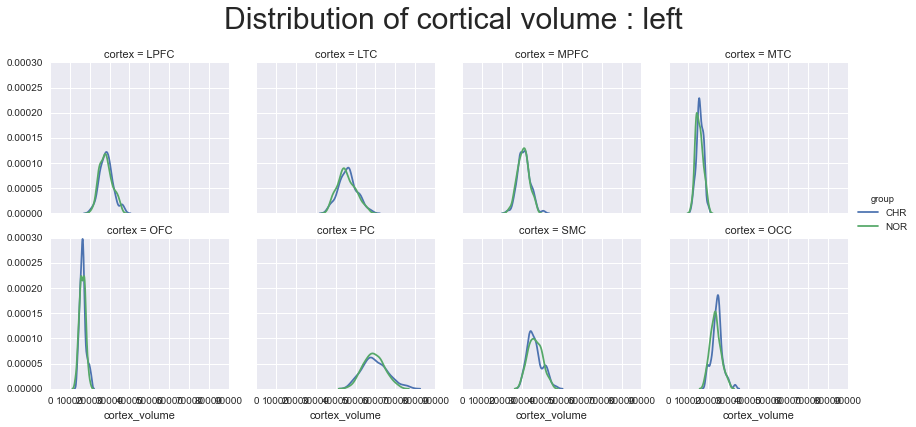

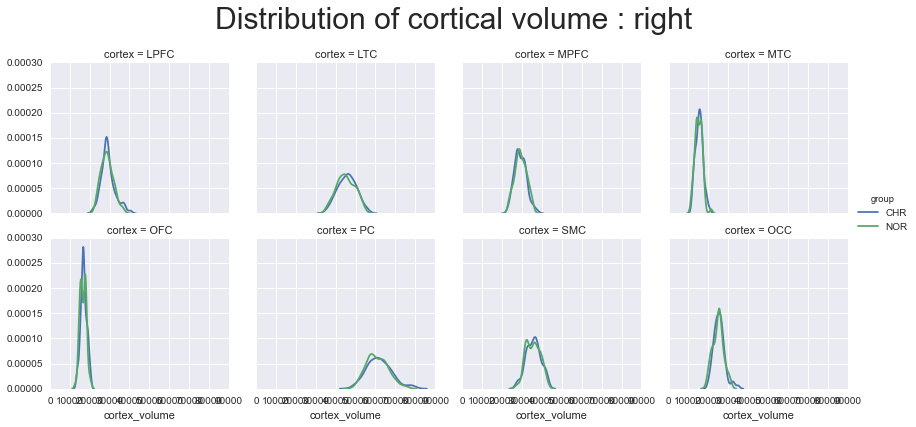

In [122]:
for side in 'left','right':
    g = sns.FacetGrid(df_matched.groupby('side').get_group(side)[['cortex',
                                                                  'thalamus_seg_volume',
                                                                  'side',
                                                                  'group',
                                                                  'cortex_volume']].drop_duplicates(), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'cortex_volume')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of cortical volume : '+side, fontsize=30)
    plt.show()

/Users/kangik/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


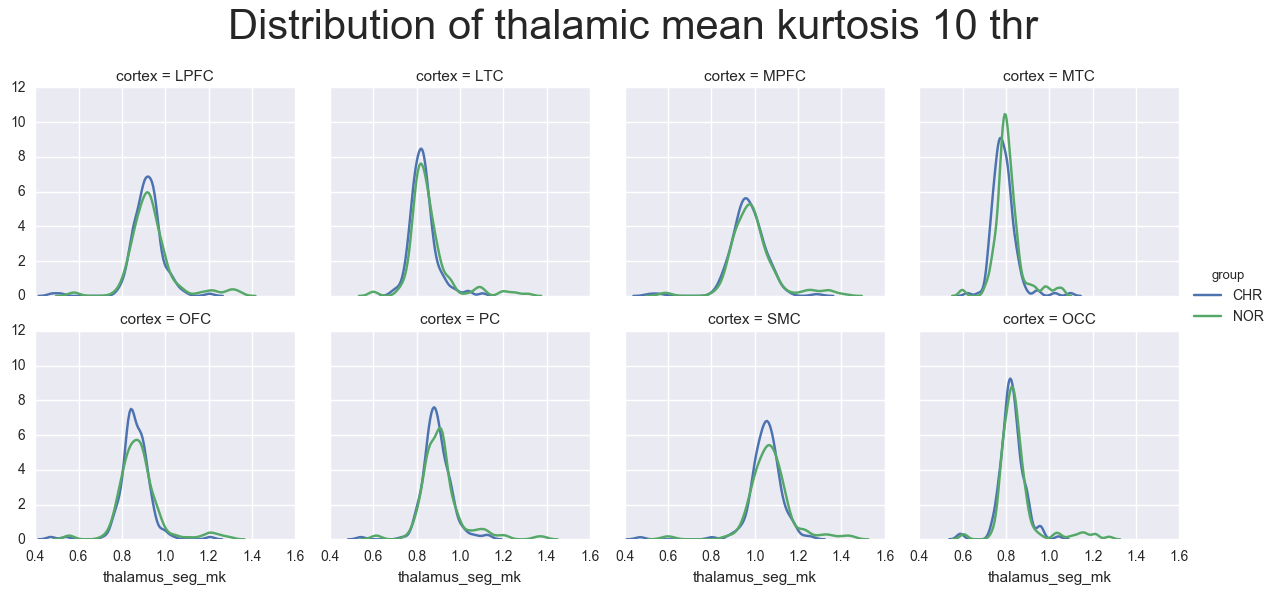

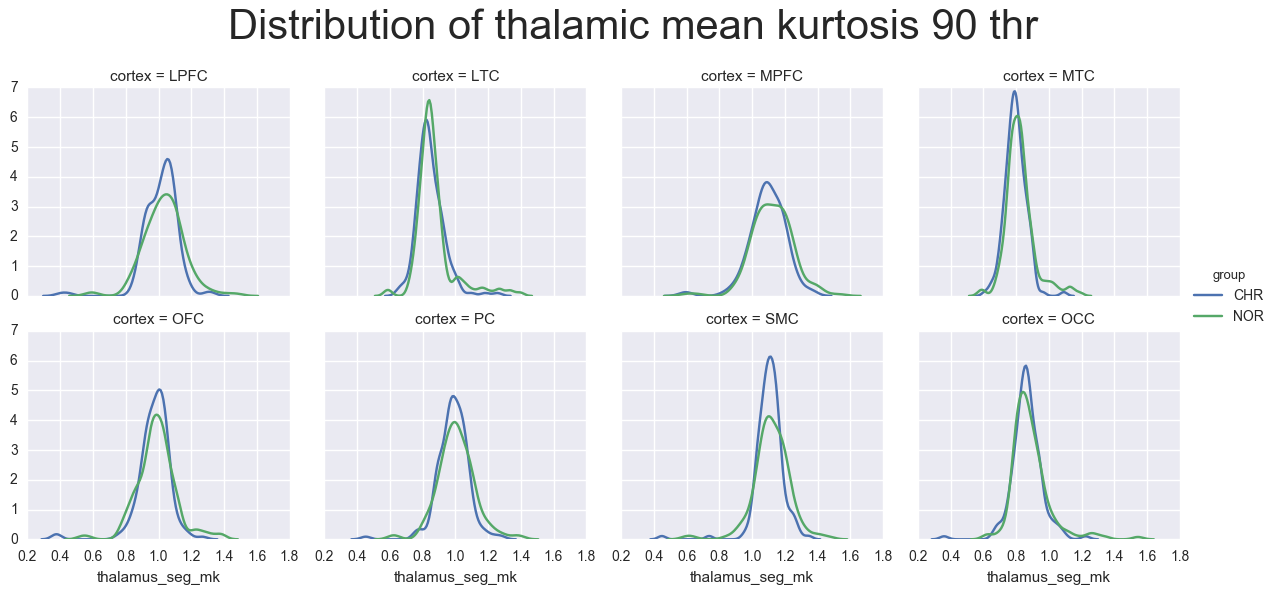

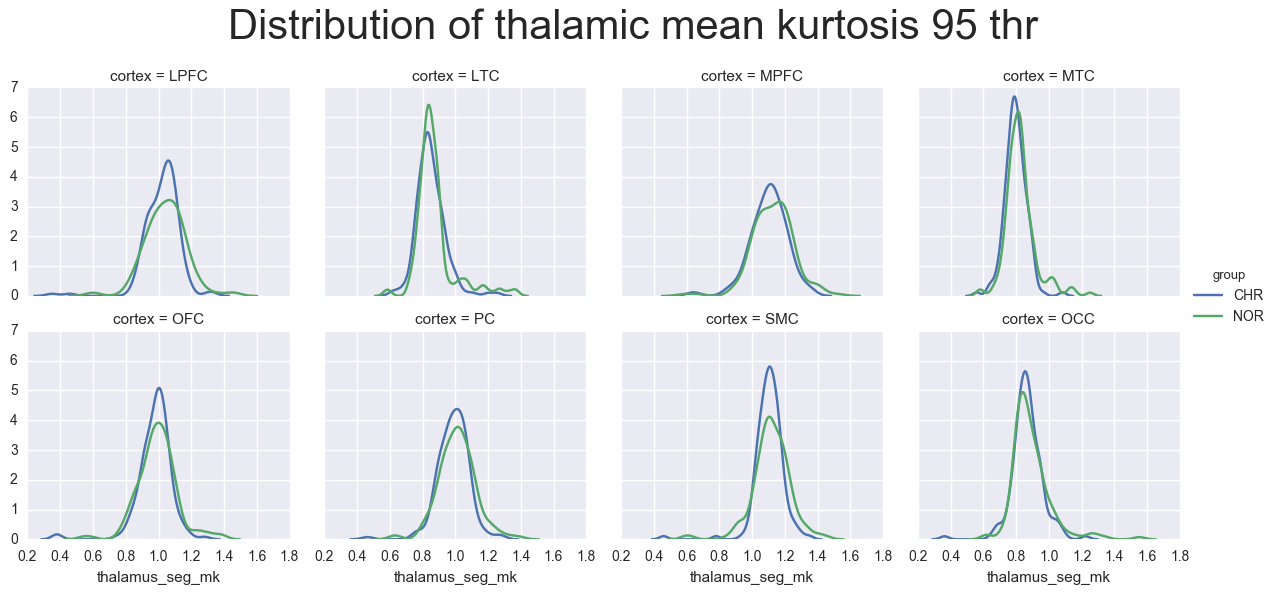

In [73]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'thalamus_seg_mk')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of thalamic mean kurtosis {0} thr'.format(thr), fontsize=30)
    plt.show()

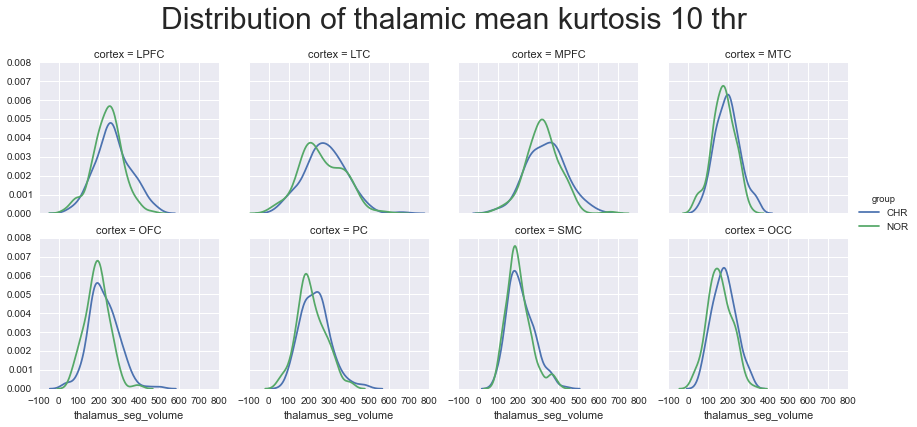

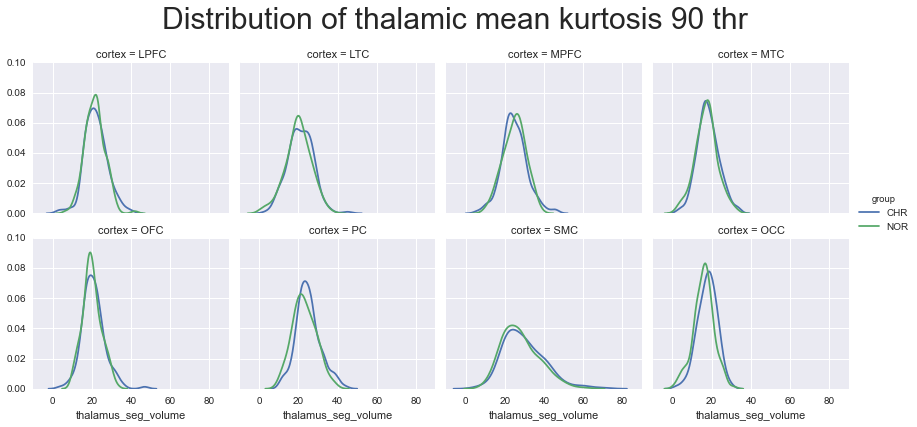

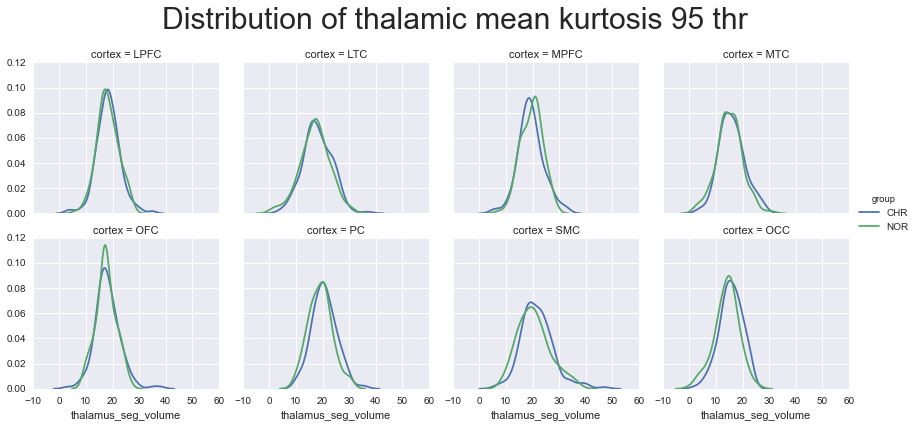

In [124]:
df_gb = df_matched.groupby('threshold')
for thr in '10', '90', '95':
    g = sns.FacetGrid(df_gb.get_group(thr), 
                      col='cortex', col_wrap=4, hue='group')
    g = (g.map(sns.kdeplot, 'thalamus_seg_volume')).add_legend()
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Distribution of thalamic mean kurtosis {0} thr'.format(thr), fontsize=30)
    plt.show()

---

# 3. Statistics

In [99]:
cortices = df_matched.roi.unique()

## Comparison of thalamic volumes

In [127]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print thr, '='*60
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_volume'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

10 ============================================================
('side', 'left')
LPFC
           df          sum_sq       mean_sq         F    PR(>F)
GROUP       1    61984.005998  61984.005998  8.319999  0.004499
AGE         1     5173.047458   5173.047458  0.694369  0.406007
SEX         1    14741.186756  14741.186756  1.978682  0.161598
Residual  150  1117500.201346   7450.001342       NaN       NaN
()
LTC
           df          sum_sq       mean_sq         F    PR(>F)
GROUP       1    52490.230401  52490.230401  4.426971  0.037043
AGE         1       33.616666     33.616666  0.002835  0.957606
SEX         1     1151.290846   1151.290846  0.097099  0.755772
Residual  150  1778537.543905  11856.916959       NaN       NaN
()
MTC
           df         sum_sq       mean_sq         F    PR(>F)
GROUP       1   34674.552119  34674.552119  9.773218  0.002127
AGE         1    3467.234290   3467.234290  0.977260  0.324468
SEX         1    3809.907212   3809.907212  1.073844  0.301747
Residual

## Comparison of cortical ROI volumes

In [133]:
df_gb = df_matched.groupby(['side','cortex'])

for side in 'left', 'right':
    print('side', side)
    print('='*80)
    compare = 'cortex_volume'
    for cortex in cortices:
        x = df_gb.get_group((side, cortex))[['subject', 'age', 'group', 'sex', compare]].drop_duplicates()
        GROUP = x['group']
        VAR = x[compare]
        AGE = x['age']
        SEX = x['sex']

        formula = 'VAR ~ GROUP + AGE + SEX'
        lm = ols(formula, x).fit()
        output = anova_lm(lm)
        if output['PR(>F)'].GROUP < 0.05:
            print(cortex)
            print(output)
            print()
    print('='*80)
    print()
    print()

('side', 'left')
()
()
('side', 'right')
()
()


## Thalamic nuclei volume left and right together

In [224]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print thr, '='*60
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_volume'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

thr 10
LPFC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   36.208203  36.208203  36.839270  3.893301e-09
AGE         1.0    0.421348   0.421348   0.428692  5.131366e-01
SEX         1.0    0.049737   0.049737   0.050604  8.221705e-01
Residual  298.0  292.895180   0.982870        NaN           NaN

MPFC
             df      sum_sq     mean_sq          F        PR(>F)
GROUP       1.0  118.226911  118.226911  92.467511  3.053451e-19
AGE         1.0    4.658600    4.658600   3.643579  5.724628e-02
SEX         1.0    0.247526    0.247526   0.193595  6.602604e-01
Residual  298.0  381.016199    1.278578        NaN           NaN

LTC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   45.774331  45.774331  48.804488  1.851185e-11
AGE         1.0    0.448150   0.448150   0.477817  4.899511e-01
SEX         1.0    0.002316   0.002316   0.002469  9.604015e-01
Residual  298.0  279.497877   0.937912        NaN           NaN

OCC
       

## Thalamic nuclei volume left and right separately

In [226]:
for thr in '10', '90', '95':
    for side in 'left', 'right':
        print('thr', thr)
        print('side', side)
        print('='*80)
        compare = 'Volume_'+thr
        for cortex in cortices:
            x = df_matched.groupby('roi').get_group(cortex).groupby('side').get_group(side)
            GROUP = x['Group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

thr 10
side left
LPFC
             df      sum_sq    mean_sq          F    PR(>F)
GROUP       1.0   21.154828  21.154828  17.677226  0.000045
AGE         1.0    0.823121   0.823121   0.687809  0.408255
SEX         1.0    0.987312   0.987312   0.825009  0.365206
Residual  147.0  175.918990   1.196728        NaN       NaN

MPFC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   55.478263  55.478263  39.517370  3.501228e-09
AGE         1.0    7.036488   7.036488   5.012116  2.667267e-02
SEX         1.0    0.070073   0.070073   0.049913  8.235250e-01
Residual  147.0  206.372656   1.403896        NaN           NaN

LTC
             df      sum_sq    mean_sq          F        PR(>F)
GROUP       1.0   31.893989  31.893989  28.760062  3.111632e-07
AGE         1.0    0.428597   0.428597   0.386483  5.351169e-01
SEX         1.0    0.013805   0.013805   0.012449  9.113143e-01
Residual  147.0  163.018302   1.108968        NaN           NaN

SMC
             df      s

## Mean kurtosis in thalamic nuclei left and right together

> 10 thrP

In [113]:
df_gb = df_matched.groupby(['threshold', 'side','cortex'])
for thr in '10', '90', '95':
    print(thr, '='*60)
    for side in 'left', 'right':
        print('side', side)
        print('='*80)
        compare = 'thalamus_seg_mk'
        for cortex in cortices:
            x = df_gb.get_group((thr, side, cortex))
            GROUP = x['group']
            VAR = x[compare]
            AGE = x['age']
            SEX = x['sex']

            formula = 'VAR ~ GROUP + AGE + SEX'
            lm = ols(formula, x).fit()
            output = anova_lm(lm)
            if output['PR(>F)'].GROUP < 0.05:
                print(cortex)
                print(output)
                print()
        print('='*80)
        print()
        print()

10 ============================================================
side left
LTC
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.023865  0.023865  4.234151  0.041350
AGE         1.0  0.033770  0.033770  5.991662  0.015528
SEX         1.0  0.011257  0.011257  1.997217  0.159660
Residual  150.0  0.845432  0.005636       NaN       NaN

MTC
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.017342  0.017342  5.088983  0.025524
AGE         1.0  0.013335  0.013335  3.913129  0.049742
SEX         1.0  0.001487  0.001487  0.436350  0.509902
Residual  150.0  0.511173  0.003408       NaN       NaN



side right
LTC
             df    sum_sq   mean_sq         F    PR(>F)
GROUP       1.0  0.030513  0.030513  3.996371  0.047405
AGE         1.0  0.038334  0.038334  5.020701  0.026515
SEX         1.0  0.047602  0.047602  6.234448  0.013609
Residual  150.0  1.145289  0.007635       NaN       NaN

MTC
             df    sum_sq   mean_sq         F    PR(>F